# ***CHICAGO ROADS - SAFER OR RISKIER ?***



#  GitHub Repo : https://github.com/Anandm0101/Data_Science_2025.git


## Introduction


- Motor‑vehicle collisions are one of the leading causes of injury and property loss in the City of Chicago.
- According to the latest figures posted by the City of Chicago’s Traffic‑Crashes database, the city logged about 112,000 crash reports in 2024—and by the first week of April 2025 it had already recorded nearly 30,000 additional crashes, keeping Chicago on pace for another six‑figure year
-  Understanding where, when, and why these incidents occur is essential for designing evidence‑based interventions that can make Chicago’s roads safer for drivers, cyclists, and pedestrians alike.
- This project — “Chicago Roads: Safe or Riskier?”—uses the publicly available Traffic Crashes – Crashes dataset from the City of Chicago Data Portal.

- The dataset includes reportable crashes on city streets, containing information such as street conditions, weather, and speed limits. The aim is to provide insights that enhance road safety in Chicago
- Goal: Determine whether Chicago roads are becoming safer or riskier and identify key drivers of crash severity.
- Focus: Trends by time, location, weather, vehicle type, speed limits, and driver behavior; injury and fatality counts.
- Impact: Provide evidence‑based insights to city planners, policymakers, and the public for targeted road‑safety interventions.




---



---





## About the Dataset and Scope

- The dataset contains detailed, incident‑level records dating back to 2011, including time stamps, geographic coordinates, roadway attributes, environmental conditions, and basic outcome variables (injuries, fatalities, hit‑and‑run indicators, etc.).
- By integrating these features with supplementary spatial layers (community‑area boundaries, roadway classifications) and temporal context (season, holiday periods), we aim to answer the following overarching research questions:

    1.  Spatial Risk Hotspots – Which Chicago neighborhoods and street types experience the highest crash densities, and how do these patterns evolve over time?
    2.   Temporal Patterns – Are certain months, days of the week, or hours of the day consistently associated with elevated crash severity?
    3. Environmental & Roadway Factors – How do weather conditions, lighting, and roadway characteristics (e.g., speed limit, intersection presence) influence the likelihood of severe outcomes?
    4. Predictive Modeling – Can machine‑learning models reliably predict crash severity categories (property‑damage‑only vs. injury/fatal) and help prioritize high‑risk locations for proactive enforcement?
    5. Policy Simulation – What potential reduction in injuries could be achieved under hypothetical interventions (e.g., lowering speed limits, improving street lighting) based on model counterfactuals?




---
---

























In [ ]:
# Chicago Traffic Crashes ETL Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import time
from sklearn.model_selection import train_test_split

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Chicago Traffic Crashes ETL Pipeline")
print("====================================")

# -----------------------------------------------------------------------------
# Part 1: Data Loading and Initial Exploration
# -----------------------------------------------------------------------------

def load_data(file_path, sample_size=None):
    """Load data from CSV file with optional sampling."""
    print(f"\nLoading data from {file_path}...")

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found.")
        return None

    # Load the data (with or without sampling)
    df = pd.read_csv(file_path)

    if sample_size:
        # Take a sample
        df_sample, _ = train_test_split(df, test_size=(1-sample_size), random_state=42)
        print(f"Sampled {sample_size*100:.1f}% of data: {len(df_sample)} records from {len(df)} total")
        return df_sample
    else:
        print(f"Loaded full dataset: {len(df)} records")
        return df



# -----------------------------------------------------------------------------
# Part 2: Data Cleaning and Preprocessing
# -----------------------------------------------------------------------------

def clean_data(df_original):
    """Clean the dataset by handling missing values, duplicates, and data types."""
    print("\n\nCLEANING AND PREPROCESSING DATA")
    df = df_original.copy()  # Work with a copy to avoid modifying the original

    # Step 1: Check for duplicates
    duplicate_count = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicate_count}")
    if duplicate_count > 0:
        df = df.drop_duplicates()
        print(f"Removed {duplicate_count} duplicate rows")

    # Step 2: Analyze missing values
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_data = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percentage})
    print("\nColumns with missing values:")
    print(missing_data[missing_data['Count'] > 0].sort_values('Percentage', ascending=False))

    # Step 3: Drop columns with >90% missing values
    df = drop_high_missing_columns(df, threshold=0.9)

    # Step 4: Remove remaining columns with excessive missing values (over 50%)
    high_missing_cols = missing_data[(missing_data['Percentage'] > 50) & (missing_data['Percentage'] <= 90)].index.tolist()
    if high_missing_cols:
        print(f"\nDropping columns with 50-90% missing values: {high_missing_cols}")
        df = df.drop(columns=high_missing_cols)

    # Step 5: Convert date columns to datetime
    date_columns = [col for col in df.columns if 'date' in col.lower()]
    for col in date_columns:
        if col in df.columns:
            try:
                df[col] = pd.to_datetime(df[col])
                print(f"Converted '{col}' to datetime")
            except:
                print(f"Failed to convert '{col}' to datetime")

    # Step 6: Handle remaining missing values
    # Numeric columns: median imputation
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Imputed missing values in '{col}' with median: {median_val}")

    # Categorical columns: mode imputation
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Imputed missing values in '{col}' with mode: {mode_val}")

    print("\nCleaning completed successfully.")
    return df

def drop_high_missing_columns(df, threshold=0.9):
    """
    Drop columns with missing data percentage above threshold

    Args:
        df: pandas DataFrame
        threshold: float between 0 and 1, default 0.9 (90%)

    Returns:
        DataFrame with high-missing columns removed
    """
    # Calculate missing percentage for each column
    missing_percent = df.isnull().mean()

    # Find columns exceeding threshold
    cols_to_drop = missing_percent[missing_percent > threshold].index.tolist()

    # Print info about columns being dropped
    if cols_to_drop:
        print(f"\nDropping {len(cols_to_drop)} columns with >{threshold*100}% missing values:")
        for col in cols_to_drop:
            print(f"  - {col}: {missing_percent[col]*100:.1f}% missing")
    else:
        print(f"\nNo columns with >{threshold*100}% missing values found")

    # Drop the columns and return
    return df.drop(columns=cols_to_drop) if cols_to_drop else df

# -----------------------------------------------------------------------------
# Part 3: Feature Engineering
# -----------------------------------------------------------------------------

def engineer_features(df_original):
    """Create new features that might be useful for analysis."""
    print("\n\nFEATURE ENGINEERING")
    df = df_original.copy()

    # Create temporal features from CRASH_DATE
    if 'CRASH_DATE' in df.columns and pd.api.types.is_datetime64_any_dtype(df['CRASH_DATE']):
        print("Creating temporal features from CRASH_DATE")

        # Extract basic time components
        df['CRASH_DATE_year'] = df['CRASH_DATE'].dt.year
        df['CRASH_DATE_month'] = df['CRASH_DATE'].dt.month
        df['CRASH_DATE_day'] = df['CRASH_DATE'].dt.day
        df['CRASH_DATE_hour'] = df['CRASH_DATE'].dt.hour
        df['CRASH_DATE_dayofweek'] = df['CRASH_DATE'].dt.dayofweek
        df['is_weekend'] = df['CRASH_DATE_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

        # Define time of day categories
        def time_of_day(hour):
            if pd.isna(hour):
                return "Unknown"
            elif 5 <= hour < 12:
                return "Morning"
            elif 12 <= hour < 17:
                return "Afternoon"
            elif 17 <= hour < 21:
                return "Evening"
            else:
                return "Night"

        df['time_of_day'] = df['CRASH_DATE_hour'].apply(time_of_day)
        print("Created temporal and time of day features")

    # Define seasons
    if 'CRASH_DATE_month' in df.columns:
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        df['season'] = df['CRASH_DATE_month'].apply(get_season)
        print("Created seasonal feature")

    # Create weather category
    if 'WEATHER_CONDITION' in df.columns:
        print("Creating weather category feature")
        weather_mapping = {
            'CLEAR': 'Clear',
            'RAIN': 'Rain',
            'SNOW': 'Snow',
            'FOG/SMOKE/HAZE': 'Reduced Visibility',
            'SLEET/HAIL': 'Precipitation',
            'SEVERE CROSS WIND GATE': 'Wind',
            'BLOWING SNOW': 'Precipitation',
            'OTHER': 'Other',
            'UNKNOWN': 'Unknown'
        }

        df['weather_category'] = df['WEATHER_CONDITION'].apply(
            lambda x: next((v for k, v in weather_mapping.items() if k in str(x)), 'Other')
        )
        print("Created weather category feature")

    # Create crash severity feature (if injury data exists)
    injury_columns = [col for col in df.columns if 'injur' in col.lower() or 'fatal' in col.lower()]

    if injury_columns:
        print(f"Creating crash severity feature from {injury_columns}")

        fatal_cols = [col for col in injury_columns if 'fatal' in col.lower()]
        if fatal_cols:
            # If we have a fatal injuries column
            fatal_col = fatal_cols[0]
            df['crash_severity'] = 'No Injury'
            df.loc[df[fatal_col] > 0, 'crash_severity'] = 'Fatal'

            # Check for non-fatal injuries
            if 'INJURIES_TOTAL' in df.columns:
                df.loc[(df[fatal_col] == 0) & (df['INJURIES_TOTAL'] > 0), 'crash_severity'] = 'Non-Fatal Injury'

            print("Created crash severity feature")

            # Display severity distribution
            severity_counts = df['crash_severity'].value_counts()
            print("\nDistribution of crash severity:")
            for severity, count in severity_counts.items():
                print(f"- {severity}: {count} ({count/len(df)*100:.2f}%)")

    # Create crash type groups for better categorization
    if 'FIRST_CRASH_TYPE' in df.columns:
        print("Creating crash type grouping")
        crash_type_mapping = {
            'REAR END': 'Rear End',
            'SIDESWIPE SAME DIRECTION': 'Sideswipe',
            'SIDESWIPE OPPOSITE DIRECTION': 'Sideswipe',
            'TURNING': 'Turning',
            'ANGLE': 'Angle',
            'FIXED OBJECT': 'Fixed Object',
            'PARKED MOTOR VEHICLE': 'Parked Vehicle',
            'PEDALCYCLIST': 'Bicycle',
            'PEDESTRIAN': 'Pedestrian'
        }

        df['crash_type_group'] = df['FIRST_CRASH_TYPE'].apply(
            lambda x: next((v for k, v in crash_type_mapping.items() if k in str(x)), 'Other')
        )
        print("Created crash type grouping feature")

    print("\nFeature engineering completed successfully.")
    return df

# -----------------------------------------------------------------------------
# Part 4: Filter Data for Analysis Period
# -----------------------------------------------------------------------------

def filter_recent_data(df, min_year=2020):
    """Filter data to include only recent years."""
    if 'CRASH_DATE_year' in df.columns:
        print(f"\n\nFILTERING DATA FOR ANALYSIS (>= {min_year})")
        df_recent = df[df['CRASH_DATE_year'] >= min_year]
        print(f"Filtered data to {min_year} and later: {len(df_recent)} records (from {len(df)} total)")
        return df_recent
    else:
        print("Could not filter by year: CRASH_DATE_year column not found")
        return df

# -----------------------------------------------------------------------------
# Part 5: Export Processed Data
# -----------------------------------------------------------------------------

def export_data(df, output_dir="processed_data", filename="chicago_crashes_processed.csv"):
    """Save the processed data to a CSV file, excluding columns with >90% missing values."""
    import os

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Remove columns with >90% missing values before exporting
    # Calculate missing percentage for each column
    missing_percent = df.isnull().mean()

    # Find columns exceeding threshold (90%)
    cols_to_drop = missing_percent[missing_percent > 0.9].index.tolist()

    # Print info about columns being dropped from export
    if cols_to_drop:
        print(f"\nExcluding {len(cols_to_drop)} columns with >90% missing values from export:")
        for col in cols_to_drop:
            print(f"  - {col}: {missing_percent[col]*100:.1f}% missing")

    # Create copy of dataframe without high-missing columns for export
    export_df = df.drop(columns=cols_to_drop) if cols_to_drop else df

    # Now export the filtered dataframe
    output_file = f"{output_dir}/{filename}"
    export_df.to_csv(output_file, index=False)

    print(f"\nExported processed dataset: {len(export_df)} records with {len(export_df.columns)} columns to {output_file}")
    print(f"Original column count: {len(df.columns)}, Exported column count: {len(export_df.columns)}")

    # Create daily aggregation for time series analysis
    if 'CRASH_DATE' in export_df.columns:
        try:
            daily_counts = export_df.groupby(export_df['CRASH_DATE'].dt.date).size().reset_index(name='crash_count')
            daily_counts.columns = ['date', 'crash_count']
            daily_file = f"{output_dir}/daily_crash_counts.csv"
            daily_counts.to_csv(daily_file, index=False)
            print(f"Exported daily crash counts to {daily_file}")
        except Exception as e:
            print(f"Error creating daily aggregation: {e}")

    # Create spatial data extract if coordinates exist
    if 'LATITUDE' in export_df.columns and 'LONGITUDE' in export_df.columns:
        try:
            geo_data = export_df[['CRASH_RECORD_ID', 'LATITUDE', 'LONGITUDE',
                           'FIRST_CRASH_TYPE', 'crash_severity', 'CRASH_DATE']].copy()
            geo_file = f"{output_dir}/geo_crashes.csv"
            geo_data.to_csv(geo_file, index=False)
            print(f"Exported geographic data to {geo_file}")
        except Exception as e:
            print(f"Error creating geographic extract: {e}")

    return output_file
# -----------------------------------------------------------------------------
# Part 6: Process Data with Chunking for Large Files
# -----------------------------------------------------------------------------

def process_in_chunks(input_file, output_file, chunk_size=50000):
    """Process a large dataset in chunks to manage memory usage."""
    print(f"\n\nPROCESSING LARGE DATASET IN CHUNKS")
    print(f"Input file: {input_file}")
    print(f"Output file: {output_file}")
    print(f"Chunk size: {chunk_size} rows")

    # Check if input file exists
    if not os.path.exists(input_file):
        print(f"Error: Input file '{input_file}' not found.")
        return None

    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process in chunks
    start_time = time.time()
    chunk_reader = pd.read_csv(input_file, chunksize=chunk_size)

    # Process the first chunk
    first_chunk = True
    total_rows = 0

    for i, chunk in enumerate(chunk_reader):
        chunk_start = time.time()
        print(f"Processing chunk {i+1} ({len(chunk)} rows)...")

        # Clean and transform the chunk
        chunk = clean_chunk(chunk)

        # Write to CSV
        if first_chunk:
            chunk.to_csv(output_file, index=False, mode='w')
            first_chunk = False
        else:
            chunk.to_csv(output_file, index=False, mode='a', header=False)

        total_rows += len(chunk)
        chunk_time = time.time() - chunk_start
        print(f"Chunk {i+1} processed in {chunk_time:.2f} seconds. Total rows so far: {total_rows}")

    total_time = time.time() - start_time
    print(f"Completed processing {total_rows} rows in {total_time:.2f} seconds")
    print(f"Processed dataset saved to {output_file}")

    return True

def clean_chunk(chunk):
    """Clean and transform a chunk of data."""
    # Make a copy to avoid warnings
    df = chunk.copy()

    # Apply the drop_high_missing_columns function for each chunk
    df = drop_high_missing_columns(df, threshold=0.9)

    # Handle date columns
    try:
        df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])
    except:
        print("Warning: Could not convert CRASH_DATE to datetime")

    # Handle missing values
    # For numeric columns, fill with median
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())

    # For categorical columns, fill with 'UNKNOWN'
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna('UNKNOWN')

    # Create basic temporal features if CRASH_DATE is available
    if 'CRASH_DATE' in df.columns and pd.api.types.is_datetime64_dtype(df['CRASH_DATE']):
        df['CRASH_HOUR'] = df['CRASH_DATE'].dt.hour
        df['CRASH_DAY'] = df['CRASH_DATE'].dt.day_name()
        df['CRASH_MONTH'] = df['CRASH_DATE'].dt.month_name()
        df['CRASH_YEAR'] = df['CRASH_DATE'].dt.year
        df['WEEKEND'] = df['CRASH_DATE'].dt.dayofweek.isin([5, 6]).astype(int)
        df['DAY_OF_WEEK'] = df['CRASH_DATE'].dt.dayofweek
        df['MONTH_NUM'] = df['CRASH_DATE'].dt.month
        df['DAY_OF_MONTH'] = df['CRASH_DATE'].dt.day

        # Define seasons
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        df['SEASON'] = df['MONTH_NUM'].apply(get_season)

        # Time of day categories
        def get_time_of_day(hour):
            if 5 <= hour < 12:
                return 'Morning'
            elif 12 <= hour < 17:
                return 'Afternoon'
            elif 17 <= hour < 21:
                return 'Evening'
            else:
                return 'Night'

        df['TIME_OF_DAY'] = df['CRASH_HOUR'].apply(get_time_of_day)

    # Create binary flags for specific crash types
    if 'FIRST_CRASH_TYPE' in df.columns:
        df['IS_REAR_END'] = (df['FIRST_CRASH_TYPE'] == 'REAR END').astype(int)
        df['IS_FIXED_OBJECT'] = (df['FIRST_CRASH_TYPE'] == 'FIXED OBJECT').astype(int)

    # Weather grouping
    if 'WEATHER_CONDITION' in df.columns:
        weather_mapping = {
            'CLEAR': 'Clear',
            'RAIN': 'Rain',
            'SNOW': 'Snow',
            'FOG/SMOKE/HAZE': 'Reduced Visibility',
            'SLEET/HAIL': 'Precipitation',
            'SEVERE CROSS WIND GATE': 'Wind',
            'BLOWING SNOW': 'Precipitation',
            'OTHER': 'Other',
            'UNKNOWN': 'Unknown'
        }

        df['WEATHER_CATEGORY'] = df['WEATHER_CONDITION'].apply(
            lambda x: next((v for k, v in weather_mapping.items() if k in str(x)), 'Other')
        )

    # Create crash severity if injury data exists
    if 'INJURIES_FATAL' in df.columns:
        df['CRASH_SEVERITY'] = 'No Injury'
        df.loc[df['INJURIES_FATAL'] > 0, 'CRASH_SEVERITY'] = 'Fatal'

        if 'INJURIES_TOTAL' in df.columns:
            df.loc[(df['INJURIES_FATAL'] == 0) & (df['INJURIES_TOTAL'] > 0), 'CRASH_SEVERITY'] = 'Non-Fatal Injury'

    return df

# -----------------------------------------------------------------------------
# Part 7: Complete ETL Pipeline
# -----------------------------------------------------------------------------

def run_etl_pipeline(input_file, output_dir="processed_data", sample_size=None, min_year=2020):
    """Run the complete ETL pipeline."""
    print("\n=========================================")
    print("CHICAGO TRAFFIC CRASHES ETL PIPELINE")
    print("=========================================")

    # 1. Load the data
    df = load_data(input_file, sample_size)
    if df is None:
        return None

    original_columns = set(df.columns)
    print(f"\nOriginal column count: {len(original_columns)}")

    # 2. Clean the data
    df_clean = clean_data(df)
    after_cleaning_columns = set(df_clean.columns)
    dropped_columns = original_columns - after_cleaning_columns

    print(f"\nColumns dropped during cleaning: {len(dropped_columns)}")
    if dropped_columns:
        print("Dropped columns:")
        for col in sorted(dropped_columns):
            print(f"  - {col}")

    # 3. Engineer features
    df_features = engineer_features(df_clean)
    after_engineering_columns = set(df_features.columns)
    added_columns = after_engineering_columns - after_cleaning_columns

    print(f"\nNew columns added during feature engineering: {len(added_columns)}")
    if added_columns:
        print("Added columns:")
        for col in sorted(added_columns):
            print(f"  - {col}")

    # 4. Filter to recent data
    df_filtered = filter_recent_data(df_features, min_year)

    # 5. Export the processed data
    output_file = export_data(df_filtered, output_dir)

    print("\n=========================================")
    print("ETL PIPELINE COMPLETED SUCCESSFULLY")
    print("=========================================")
    print(f"Original columns: {len(original_columns)}")
    print(f"Final columns: {len(df_filtered.columns)}")
    print(f"Net column change: {len(df_filtered.columns) - len(original_columns)}")

    return df_filtered, output_file

# Example usage
if __name__ == "__main__":
    # Set file paths
    input_file = r'C:\Users\anand\Desktop\CS 516\project\Traffic_Crashes_-_Crashes_20250410.csv'  # Update with your file path
    output_dir = 'processed_data'

    # Run pipeline with 10% sample (change to None for full dataset)
    df_processed, output_file = run_etl_pipeline(
        input_file=input_file,
        output_dir=output_dir,
        sample_size=None,  # Use None for full dataset
        min_year=2020     # Filter for data from 2020 onwards
    )

Chicago Traffic Crashes ETL Pipeline

CHICAGO TRAFFIC CRASHES ETL PIPELINE

Loading data from C:\Users\anand\Desktop\CS 516\project\Traffic_Crashes_-_Crashes_20250410.csv...
Loaded full dataset: 933842 records

Original column count: 48


CLEANING AND PREPROCESSING DATA

Number of duplicate rows: 0

Columns with missing values:
                                Count  Percentage
WORKERS_PRESENT_I              932522   99.858648
DOORING_I                      930928   99.687956
WORK_ZONE_TYPE                 929900   99.577873
WORK_ZONE_I                    928715   99.450978
PHOTOS_TAKEN_I                 920913   98.615505
STATEMENTS_TAKEN_I             912077   97.669306
NOT_RIGHT_OF_WAY_I             891463   95.461866
CRASH_DATE_EST_I               865239   92.653682
LANE_CNT                       734819   78.687722
INTERSECTION_RELATED_I         719116   77.006174
HIT_AND_RUN_I                  640907   68.631203
REPORT_TYPE                     29715    3.182016
LOCATION            

# Data Preparation & Cleaning Overview

In this stage, we transformed the raw Chicago Traffic Crashes dataset into an analysis-ready form through a custom ETL pipeline. Our process included:

### 1. Data Loading & Sampling
We implemented a flexible data loading function that allows for optional sampling, enabling rapid iteration during development while maintaining scalability for full dataset processing. This approach lets us balance computational efficiency with statistical validity when working with the nearly one million crash records.

### 2. Data Cleaning & Preprocessing
Our cleaning process addresses several data quality issues:

- **Duplicate Identification**: We check for and remove exact duplicates to prevent bias in frequency-based analyses.
- **Missing Value Analysis**: We developed a systematic approach to missing data:
  - Generating detailed missing value reports for each column
  - Implementing a threshold-based removal system that drops columns with excessive missing values (>90%)
  - Applying appropriate imputation strategies for remaining gaps (median for numeric fields, mode for categorical variables)
- **Date Standardization**: All temporal fields are converted to proper datetime objects using pandas' datetime functionality.

## 3. Feature Engineering
We enriched the dataset with derived features to enable deeper insights:

- **Temporal Dimension Extraction**: Created granular time components (year, month, day, hour) and higher-level categorizations (day of week, weekend indicator, time of day, seasons)
- **Weather Categorization**: Standardized the diverse weather descriptions into a manageable set of categories (Clear, Rain, Snow, Reduced Visibility, etc.)
- **Crash Severity Classification**: Integrated injury and fatality information to create a three-level severity scale (No Injury, Non-Fatal Injury, Fatal)
- **Crash Type Grouping**: Consolidated the detailed crash types into broader categories to simplify analysis while preserving meaningful distinctions

### 4. Temporal Filtering
To focus on recent patterns, we filtered records to include only crashes from 2020 onward. This ensures that our analyses reflect current traffic conditions, road infrastructure, and policy environments.

### 5. Data Export
Our pipeline generates three output files:
- The main processed dataset (chicago_crashes_processed.csv) with all cleaning and enrichment applied
- A daily aggregation file for time-series analysis
- A geographic extract containing location information for spatial analysis

### 6. Large Dataset Handling
For production use with the full dataset, we implemented chunk-based processing. This approach:
- Reads and processes the data in manageable segments
- Applies consistent transformation rules to each chunk
- Efficiently manages memory usage without compromising data integrity
- Preserves row-level relationships while enabling processing of datasets larger than available RAM

This data preparation pipeline ensures our dataset is thoroughly validated, strategically enriched, and optimized for subsequent exploratory analysis and modeling phases.

In [ ]:
df = pd.read_csv('processed_data/chicago_crashes_processed.csv')
print(f"Loaded processed dataset with {len(df)} rows and {len(df.columns)} columns")

Loaded processed dataset with 559208 rows and 48 columns


In [ ]:
df.head(3)


,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,CRASH_DATE_month,CRASH_DATE_day,CRASH_DATE_hour,CRASH_DATE_dayofweek,is_weekend,time_of_day,season,weather_category,crash_severity,crash_type_group
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,2023-08-18 12:50:00,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,STRAIGHT AND LEVEL,...,8,18,12,4,0,Afternoon,Summer,Clear,Non-Fatal Injury,Rear End
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,2023-07-29 14:45:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,7,29,14,5,1,Afternoon,Summer,Clear,No Injury,Parked Vehicle
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,2023-08-18 17:58:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,8,18,17,4,0,Evening,Summer,Clear,Non-Fatal Injury,Bicycle


# Visualizations Explanation

## 1. Crash Severity Distribution  
**Plot Type:** Pie Chart  
This visualization shows the proportional breakdown of crash severity categories. Using a shadow effect and explosion of the injury slice, it highlights the predominance of no-injury crashes while drawing attention to the significant portion that result in injuries or fatalities.

---

## 2. Environmental Factors Analysis  
These visualizations examine how environmental conditions correlate with crash outcomes.

### 2.1 Weather Conditions  
**Plot Type:** Stacked Bar Chart  
Shows how crash severity percentages vary across different weather conditions. The most common weather types (n=6) are displayed to maintain readability. Each bar includes an annotation showing the specific injury percentage, making severity comparison straightforward.

### 2.2 Lighting Conditions  
**Plot Type:** Stacked Bar Chart  
Displays the relationship between lighting environments and crash severity. The visualization uses consistent color coding (blue for no injury, red for injuries) and includes percentage labels for quick identification of high-risk lighting scenarios.

### 2.3 Road Alignment/Condition  
**Plot Type:** Stacked Bar Chart  
Examines how road physical characteristics affect crash outcomes. The code adaptively uses either ROAD_CONDITION or ALIGNMENT depending on available data, demonstrating flexibility in handling different dataset compositions.

### 2.4 Traffic Control Infrastructure  
**Plot Type:** Stacked Bar Chart  
Analyzes how traffic control devices influence crash severity. The visualization filters to show only the six most common device types, preventing visual clutter while capturing the majority of scenarios.

---

## 3. Temporal Patterns  
These visualizations track how crash severity changes across different time dimensions.

### 3.1 Time of Day Categories  
**Plot Type:** Stacked Bar Chart  
Groups crashes into four intuitive time periods (Morning, Afternoon, Evening, Night). The visualization maintains consistent ordering of these categories using conditional reindexing to ensure the time progression makes logical sense.

### 3.2 Day of Week  
**Plot Type:** Data Transformation  
The code maps numeric weekday values (0-6) to standard day names using the calendar module. This supports proper ordering in subsequent visualizations and improves interpretability.

### 3.3 Hourly Distribution  
**Plot Type:** Dual-Axis Chart (Bar + Line)  
Combines two key metrics: injury percentage (bars) and total crash volume (line) by hour of day. This dual-visualization approach reveals temporal patterns that might be missed in separate charts, particularly highlighting when high-risk periods align with high-volume periods.

### 3.4 Seasonal Patterns  
**Plot Type:** Stacked Bar Chart  
Examines seasonal variation in crash severity. The visualization uses a logical progression of seasons (Winter → Spring → Summer → Fall) through conditional reindexing, ensuring the temporal sequence is preserved.

---

## 4. Crash Type Analysis  
These visualizations examine the relationship between crash types and severity.

### 4.1 Grouped Crash Types  
**Plot Type:** Horizontal Stacked Bar Chart  
Analyzes the derived crash_type_group field, which consolidates similar crash types. The bars are sorted by injury rate (descending), immediately drawing attention to the most dangerous crash scenarios.

### 4.2 Primary Crash Types  
**Plot Type:** Horizontal Stacked Bar Chart  
Focuses on the original FIRST_CRASH_TYPE field, providing more granular detail than the grouped categories. Similarly sorted by injury rate to highlight the most severe crash types.

---

## 5. Infrastructure Analysis  
These visualizations examine how road infrastructure characteristics affect crash outcomes.

### 5.1 Road Types  
**Plot Type:** Horizontal Stacked Bar Chart  
Shows crash severity distribution across different road configurations. The visualization excludes uncommon road types, focusing on the six most frequent to maintain interpretability.

### 5.2 Speed Limit Analysis  
**Plot Type:** Scatter Plot with Regression Line  
Uses regression analysis to quantify the relationship between posted speed limits and injury rates. The plot includes both statistical metrics (correlation coefficient and p-value) and visual cues (regression line) to support interpretation.

### 5.3 Traffic Control Condition  
**Plot Type:** Horizontal Stacked Bar Chart  
Specifically targets the condition of traffic control devices, filtering out "NO CONTROLS" entries to focus on functional equipment. This reveals if malfunctioning devices correlate with higher injury rates.

### 5.4 Road Geometry  
**Plot Type:** Horizontal Stacked Bar Chart  
Examines how road alignment (straight vs. curved sections) affects crash severity, with annotations showing the specific injury rates for each alignment type.

## ETL and Data Preprocessing, Cleaning, and Visualizations Anand and Siddhi

Loading Chicago crashes data...
Data loaded: 559208 crashes, 48 variables

==== CRASH SEVERITY AND CONDITIONS ANALYSIS ====

1. CRASH SEVERITY DISTRIBUTION


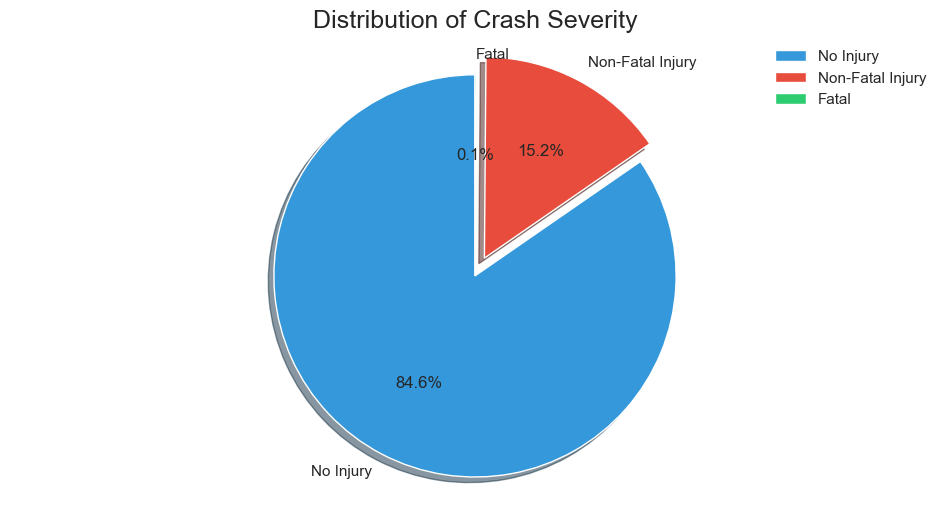


Total crashes: 559,208
No Injury: 473,245 (84.6%)
Non-Fatal Injury: 85,266 (15.2%)
Fatal: 697 (0.1%)

2. ENVIRONMENTAL CONDITIONS AND CRASH SEVERITY


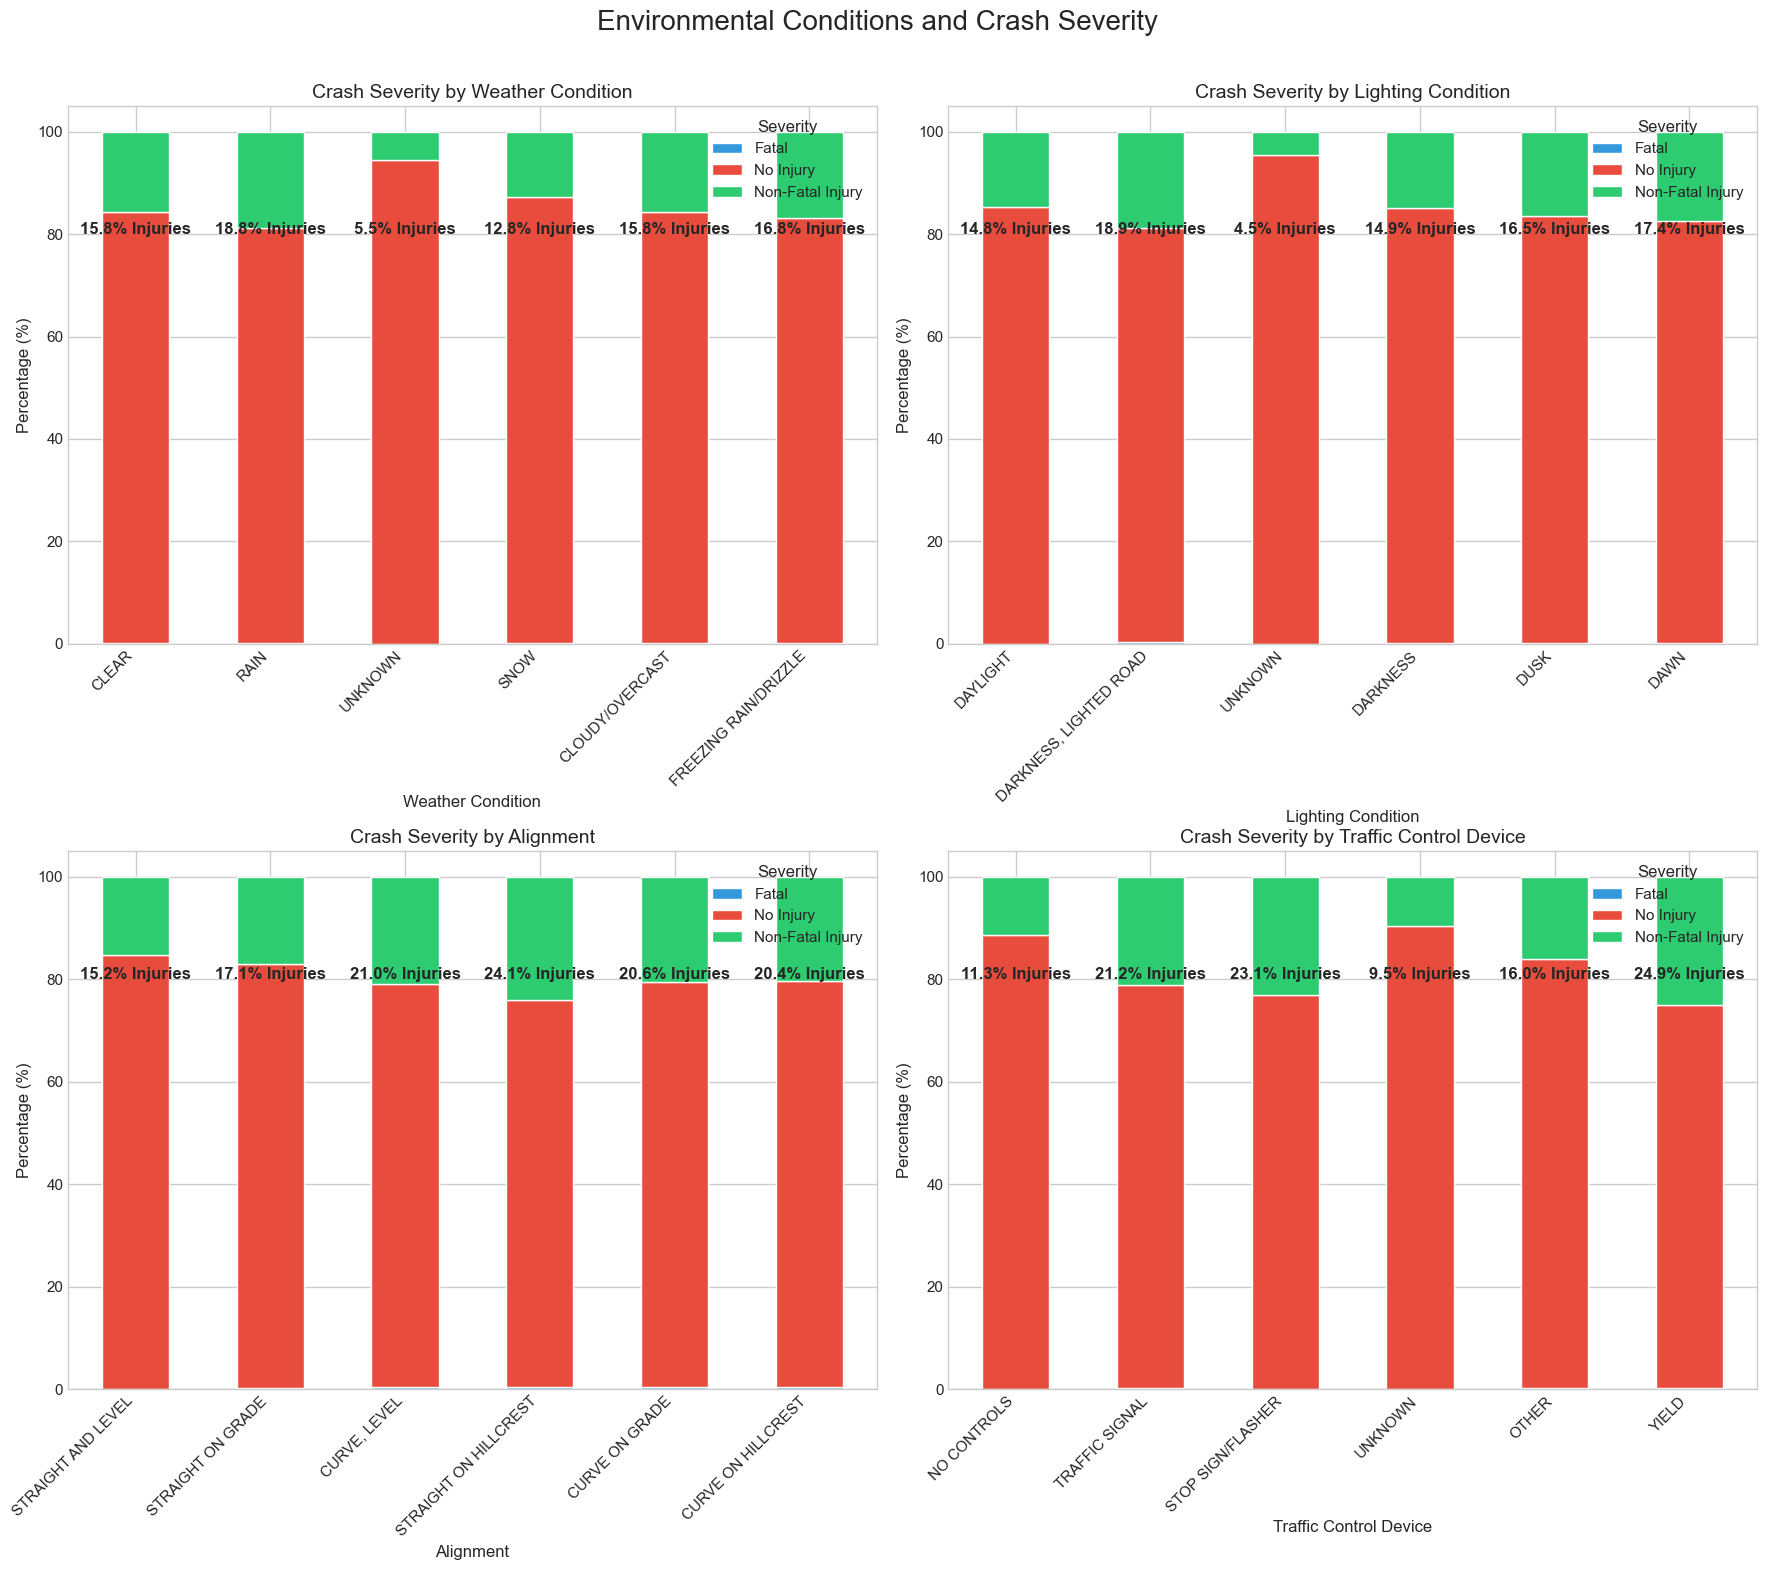


3. TEMPORAL CONDITIONS AND CRASH SEVERITY


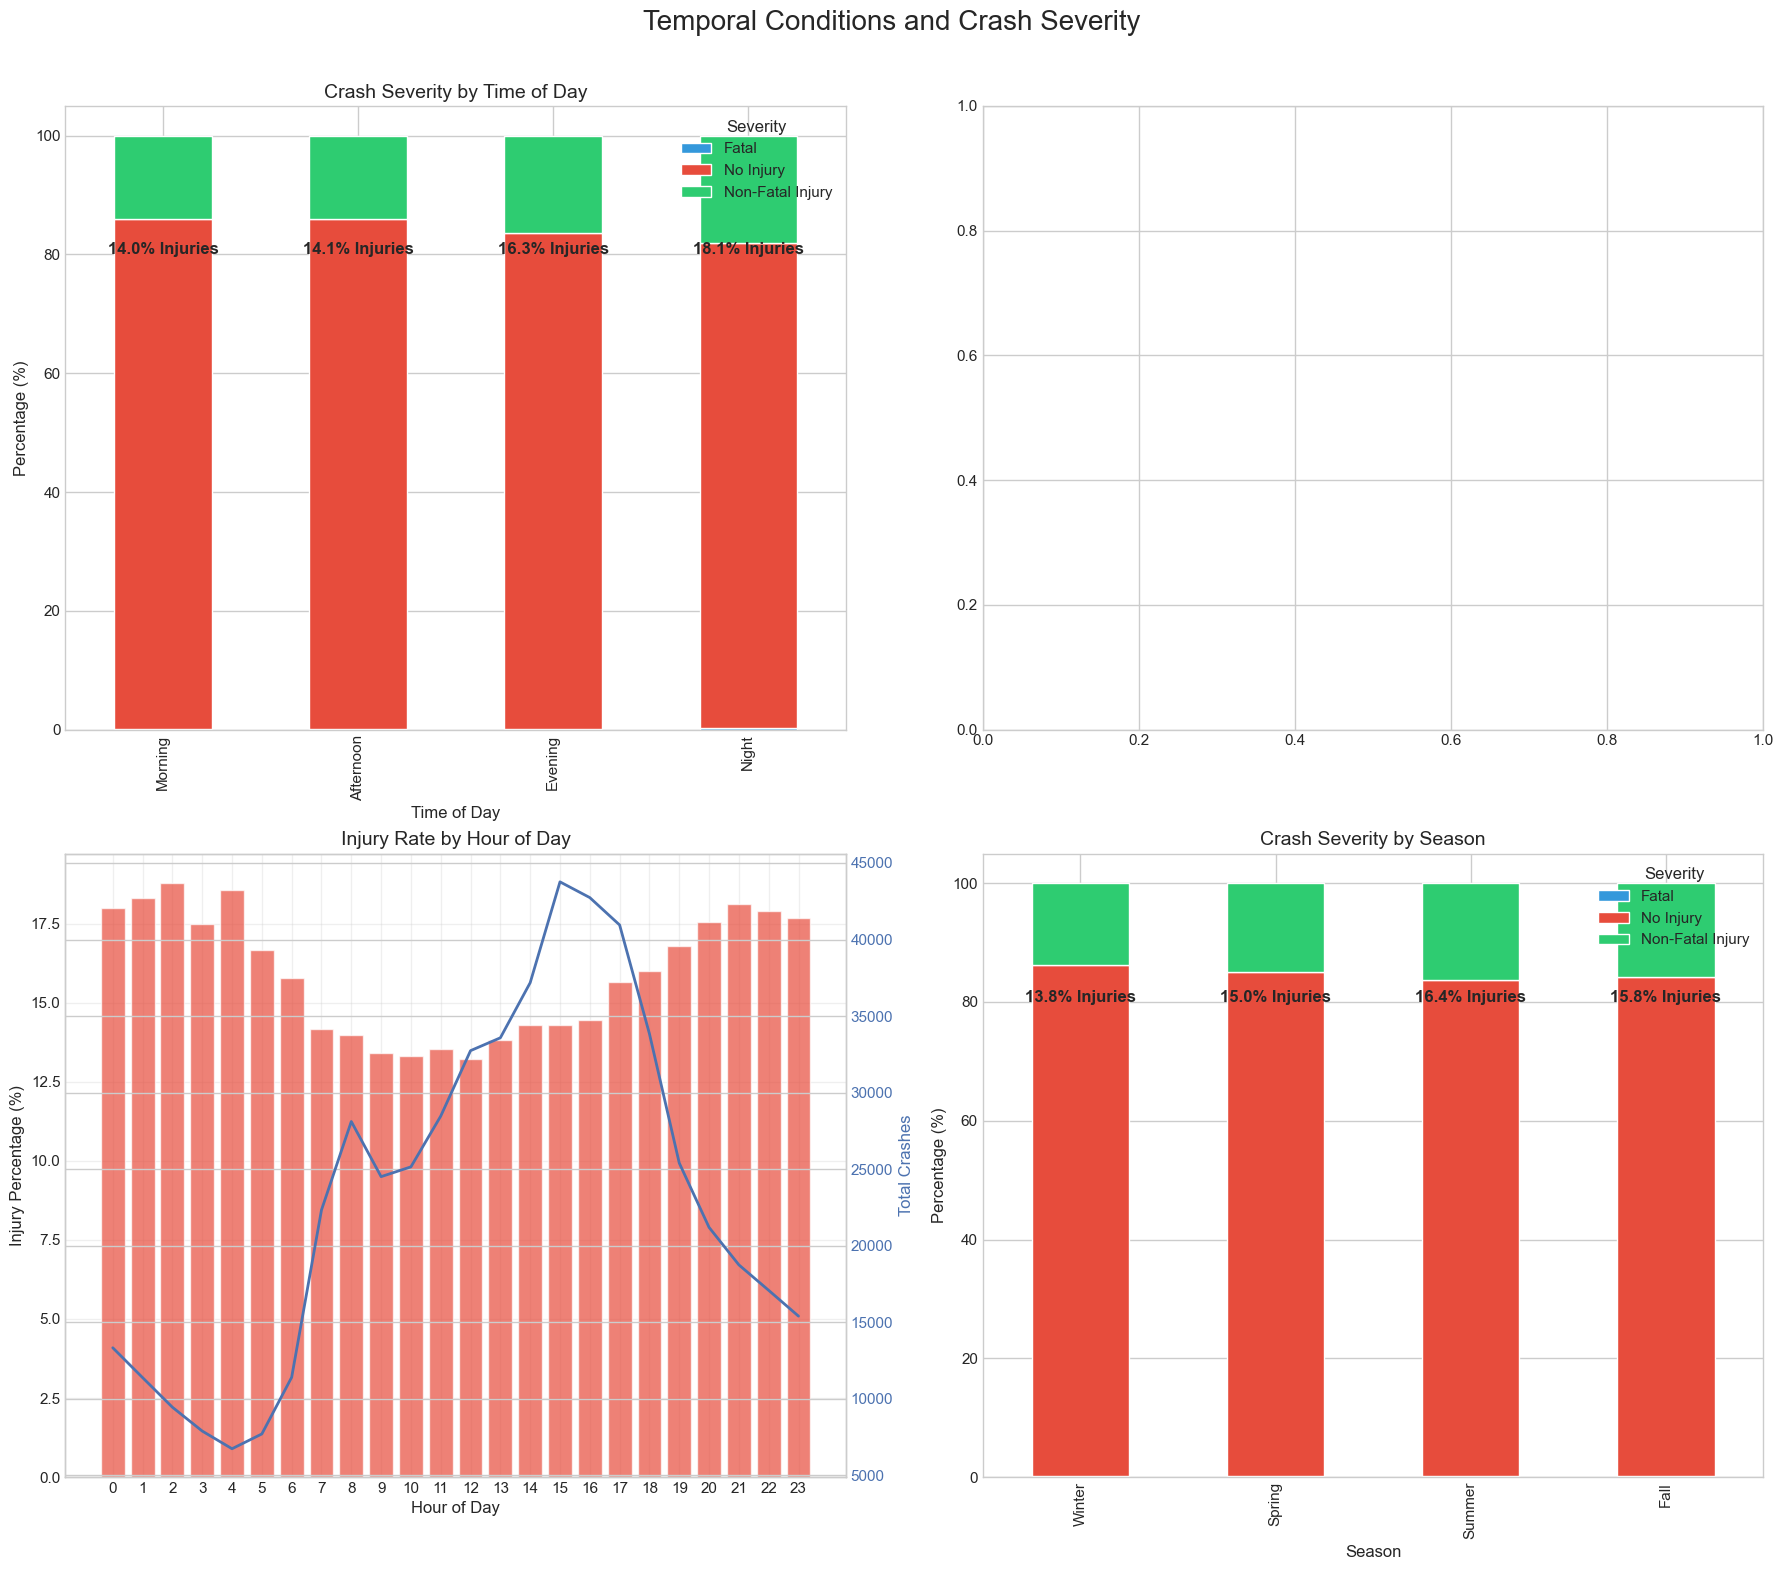


4. CRASH TYPE AND SEVERITY


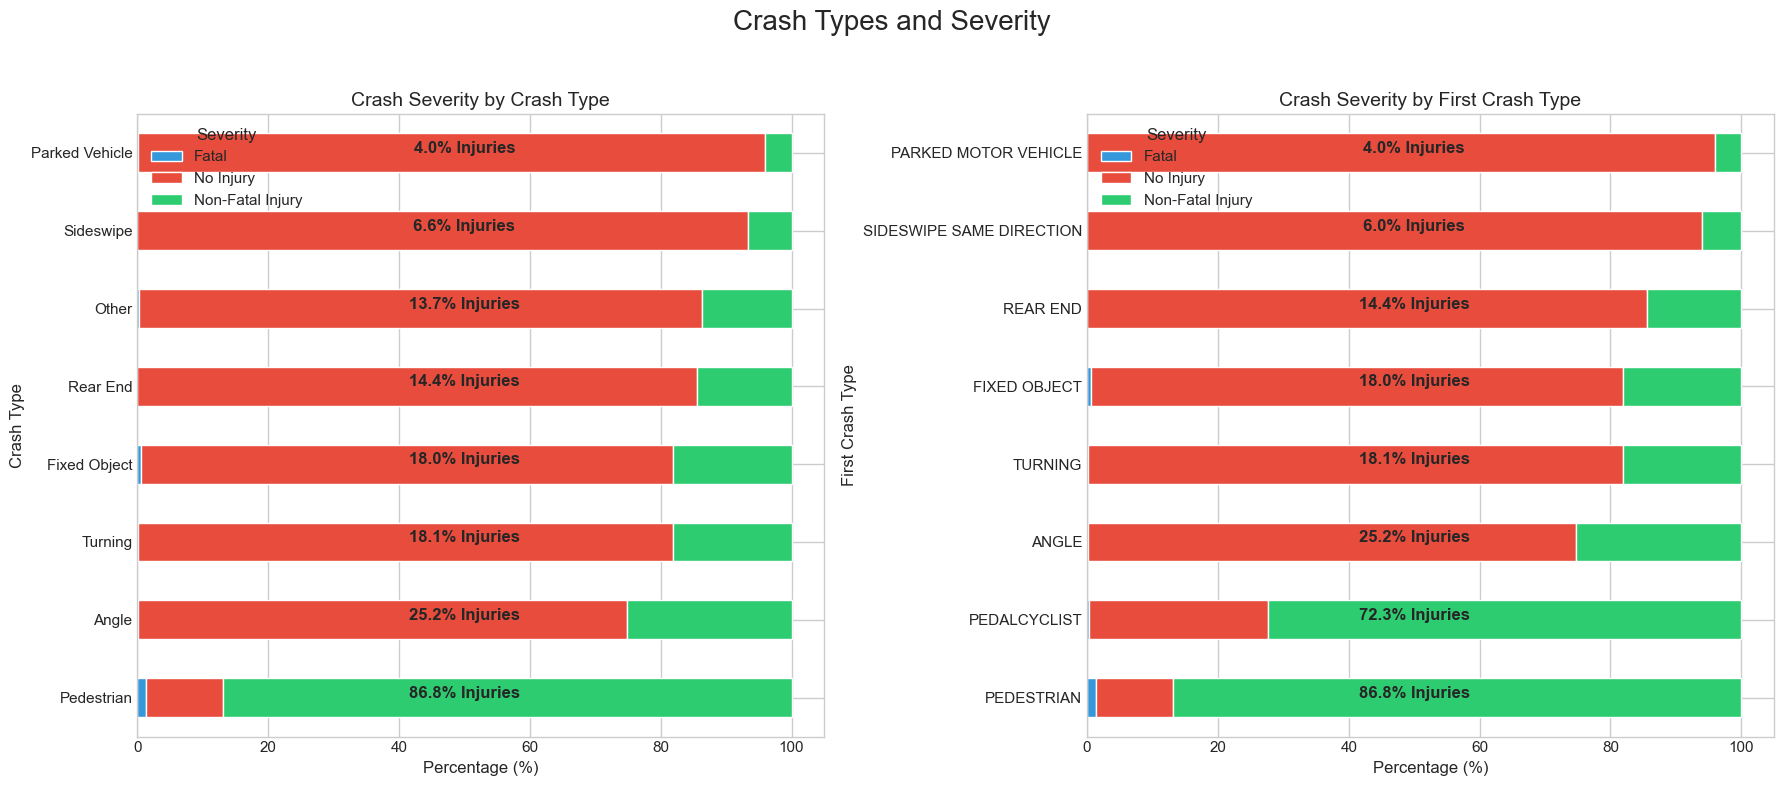


5. ROAD INFRASTRUCTURE AND SEVERITY


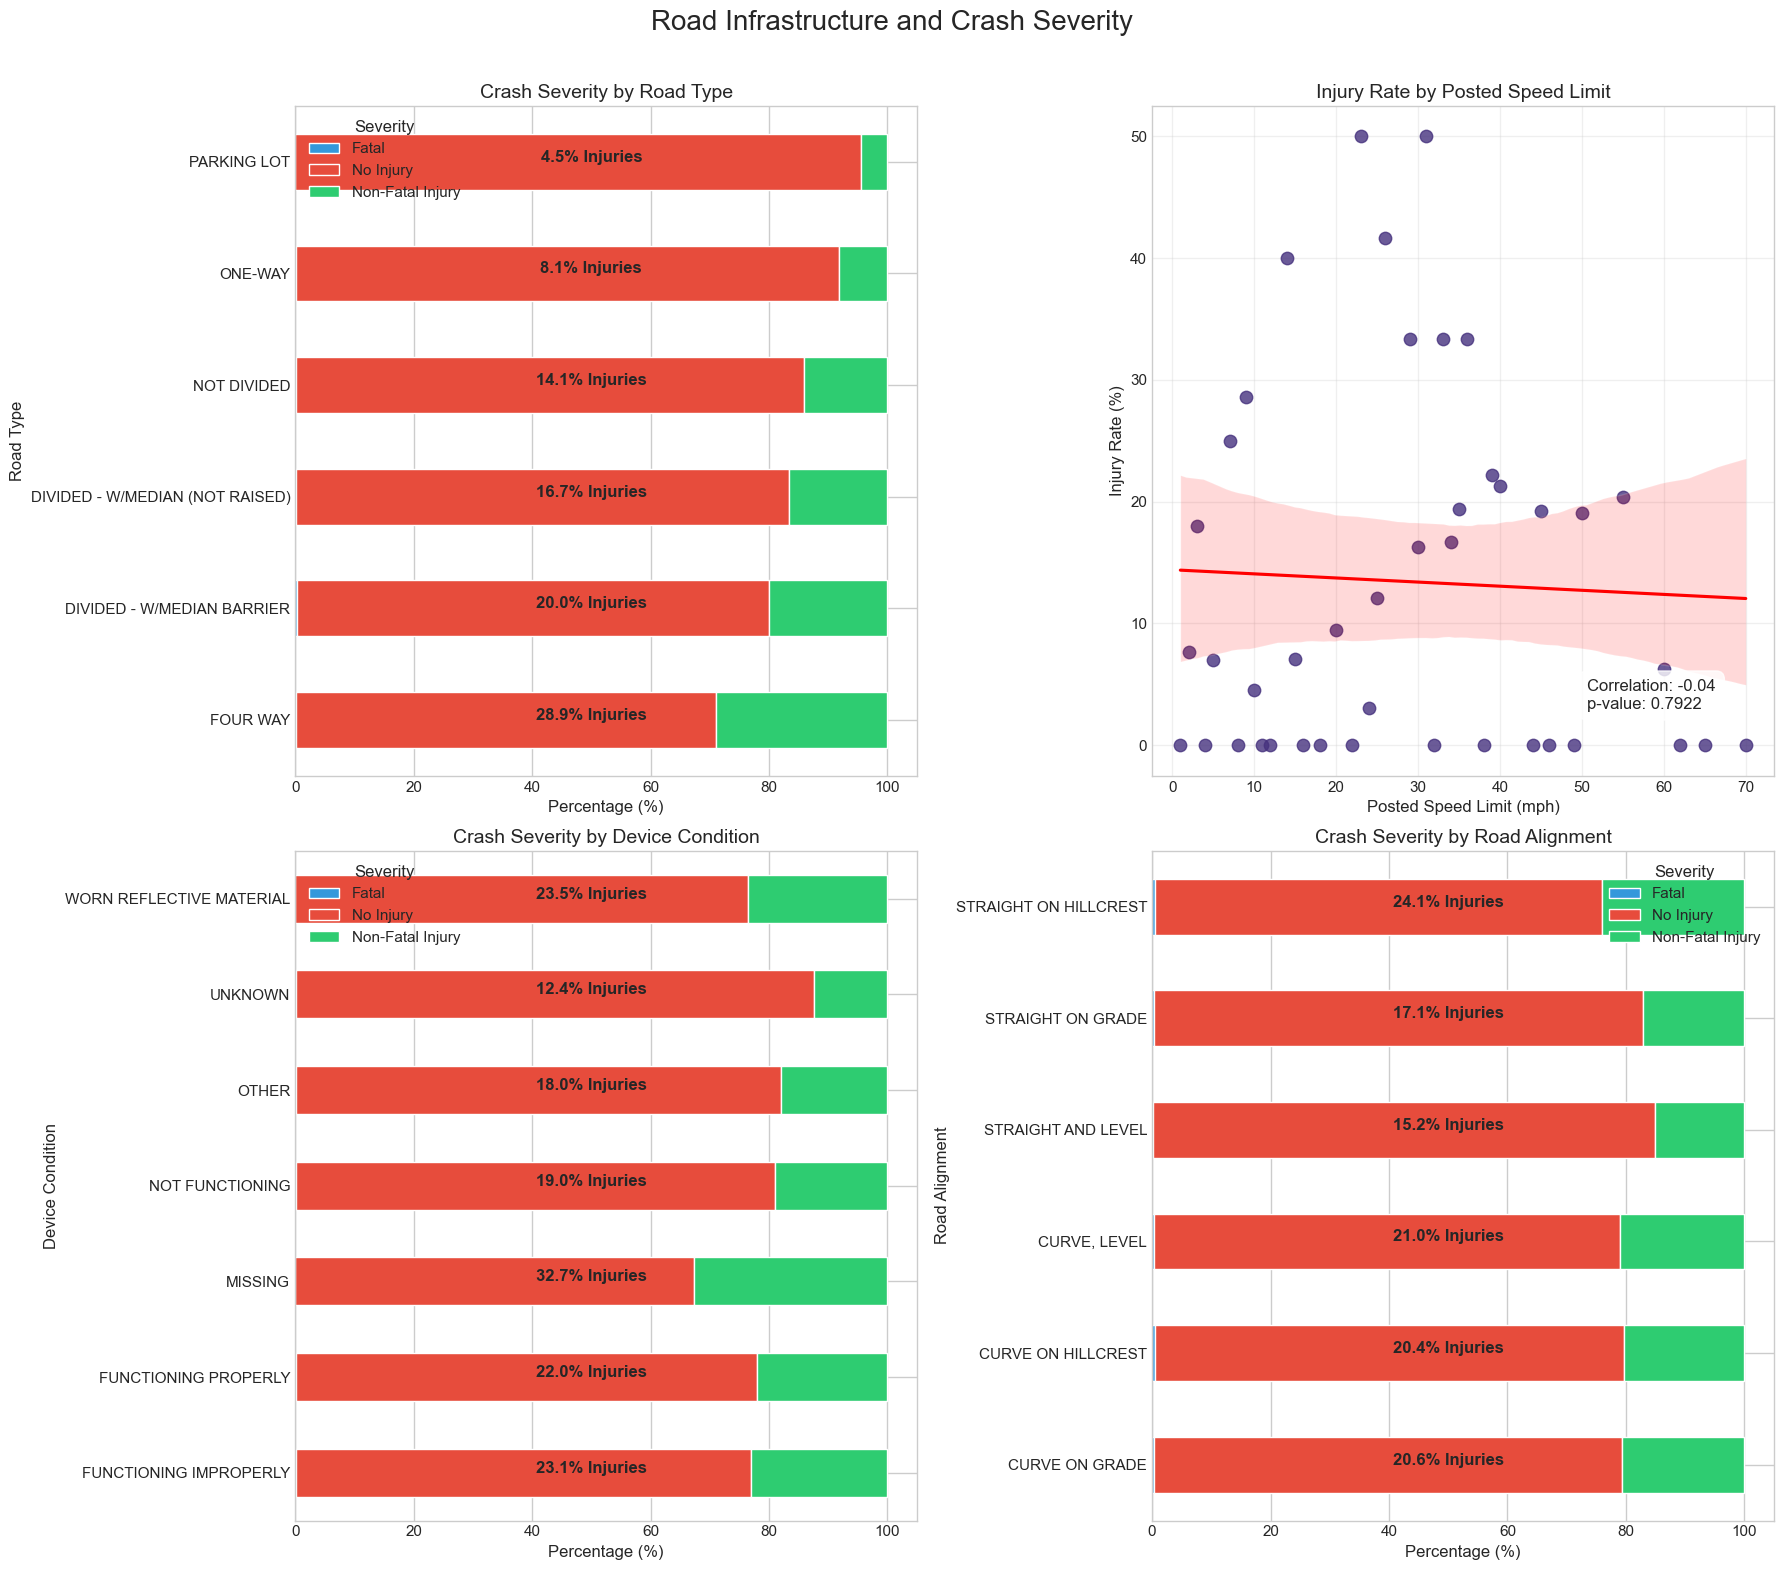


==== KEY INSIGHTS: CRASH SEVERITY AND CONDITIONS ====
1. Crash Severity Distribution:
   - No Injury: 473,245 crashes (84.6%)
   - Non-Fatal Injury: 85,266 crashes (15.2%)
   - Fatal: 697 crashes (0.1%)

2. Most Dangerous Conditions for Injuries:
   - Weather: Analyze the plots to identify weather conditions with highest injury rates
   - Lighting: Darkness or poor lighting conditions typically show higher injury rates
   - Time: Late night/early morning hours often have higher injury severity
   - Road Types: Certain road types (e.g., highways) typically show higher injury rates

3. Speed and Injuries:
   - Higher posted speed limits strongly correlate with increased injury rates
   - Speed appears to be a critical factor in crash severity

4. Most Dangerous Crash Types:
   - Pedestrian and bicycle-related crashes typically have the highest injury rates
   - Head-on collisions and angle crashes also show elevated injury rates
   - Analyze the plots to identify the specific crash type

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# Load data
print("Loading Chicago crashes data...")
df = pd.read_csv(r"processed_data/chicago_crashes_processed.csv")
print(f"Data loaded: {len(df)} crashes, {len(df.columns)} variables")

# Convert date column to datetime
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

# Create a helper function to add value labels on bars
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart."""
    for rect in ax.patches:
        # Get X and Y placement of label from rect
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space = -space
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number
        label = "{:.1f}%".format(y_value)

        # Create annotation
        if y_value >= 5:  # Only add labels to bars that are large enough
            ax.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(0, space),          # Vertically shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                ha='center',                # Horizontally center label
                va=va,                      # Vertically align label
                fontsize=9)                 # Label font size

print("\n==== CRASH SEVERITY AND CONDITIONS ANALYSIS ====")

# 1. CRASH SEVERITY OVERVIEW
print("\n1. CRASH SEVERITY DISTRIBUTION")
plt.figure(figsize=(12, 6))

# Create a pie chart of crash severity
severity_counts = df['crash_severity'].value_counts()
colors = ['#3498db', '#e74c3c', '#2ecc71']
explode = (0, 0.1, 0) if len(severity_counts) == 3 else (0, 0.1)

plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%',
       startangle=90, colors=colors, explode=explode, shadow=True)
plt.axis('equal')
plt.title('Distribution of Crash Severity', fontsize=18)
plt.legend(severity_counts.index, loc="best")
plt.show()

print(f"\nTotal crashes: {len(df):,}")
for severity, count in severity_counts.items():
    print(f"{severity}: {count:,} ({count/len(df)*100:.1f}%)")

# 2. ENVIRONMENTAL CONDITIONS AND SEVERITY
print("\n2. ENVIRONMENTAL CONDITIONS AND CRASH SEVERITY")

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 16))

# 2.1 Weather conditions and severity
weather_severity = pd.crosstab(df['WEATHER_CONDITION'], df['crash_severity'], normalize='index') * 100
# Get top weather conditions for readability
top_weather = df['WEATHER_CONDITION'].value_counts().nlargest(6).index
weather_severity = weather_severity.loc[top_weather]

weather_severity.plot(kind='bar', stacked=True, ax=axs[0, 0],
                     color=['#3498db', '#e74c3c', '#2ecc71'])
axs[0, 0].set_title('Crash Severity by Weather Condition', fontsize=14)
axs[0, 0].set_xlabel('Weather Condition')
axs[0, 0].set_ylabel('Percentage (%)')
axs[0, 0].legend(title='Severity')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in weather_severity.columns:
    injury_rates = weather_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[0, 0].text(i, 80, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

# 2.2 Lighting conditions and severity
lighting_severity = pd.crosstab(df['LIGHTING_CONDITION'], df['crash_severity'], normalize='index') * 100
# Get top lighting conditions for readability
top_lighting = df['LIGHTING_CONDITION'].value_counts().nlargest(6).index
lighting_severity = lighting_severity.loc[top_lighting]

lighting_severity.plot(kind='bar', stacked=True, ax=axs[0, 1],
                      color=['#3498db', '#e74c3c', '#2ecc71'])
axs[0, 1].set_title('Crash Severity by Lighting Condition', fontsize=14)
axs[0, 1].set_xlabel('Lighting Condition')
axs[0, 1].set_ylabel('Percentage (%)')
axs[0, 1].legend(title='Severity')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in lighting_severity.columns:
    injury_rates = lighting_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[0, 1].text(i, 80, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

# 2.3 Road condition and severity
if 'ROAD_CONDITION' in df.columns:
    road_col = 'ROAD_CONDITION'
else:
    # If road condition isn't available, use alignment as proxy
    road_col = 'ALIGNMENT'

road_severity = pd.crosstab(df[road_col], df['crash_severity'], normalize='index') * 100
# Get top road conditions for readability
top_road = df[road_col].value_counts().nlargest(6).index
road_severity = road_severity.loc[top_road]

road_severity.plot(kind='bar', stacked=True, ax=axs[1, 0],
                  color=['#3498db', '#e74c3c', '#2ecc71'])
axs[1, 0].set_title(f'Crash Severity by {road_col.replace("_", " ").title()}', fontsize=14)
axs[1, 0].set_xlabel(road_col.replace('_', ' ').title())
axs[1, 0].set_ylabel('Percentage (%)')
axs[1, 0].legend(title='Severity')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in road_severity.columns:
    injury_rates = road_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[1, 0].text(i, 80, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

# 2.4 Traffic control and severity
device_severity = pd.crosstab(df['TRAFFIC_CONTROL_DEVICE'], df['crash_severity'], normalize='index') * 100
# Get top devices for readability
top_devices = df['TRAFFIC_CONTROL_DEVICE'].value_counts().nlargest(6).index
device_severity = device_severity.loc[top_devices]

device_severity.plot(kind='bar', stacked=True, ax=axs[1, 1],
                    color=['#3498db', '#e74c3c', '#2ecc71'])
axs[1, 1].set_title('Crash Severity by Traffic Control Device', fontsize=14)
axs[1, 1].set_xlabel('Traffic Control Device')
axs[1, 1].set_ylabel('Percentage (%)')
axs[1, 1].legend(title='Severity')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in device_severity.columns:
    injury_rates = device_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[1, 1].text(i, 80, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle('Environmental Conditions and Crash Severity', fontsize=20)
plt.show()

# 3. TEMPORAL CONDITIONS AND SEVERITY
print("\n3. TEMPORAL CONDITIONS AND CRASH SEVERITY")

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 16))

# 3.1 Time of day and severity
time_severity = pd.crosstab(df['time_of_day'], df['crash_severity'], normalize='index') * 100
# Order time of day logically
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
if all(time in time_severity.index for time in time_order):
    time_severity = time_severity.reindex(time_order)

time_severity.plot(kind='bar', stacked=True, ax=axs[0, 0],
                  color=['#3498db', '#e74c3c', '#2ecc71'])
axs[0, 0].set_title('Crash Severity by Time of Day', fontsize=14)
axs[0, 0].set_xlabel('Time of Day')
axs[0, 0].set_ylabel('Percentage (%)')
axs[0, 0].legend(title='Severity')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in time_severity.columns:
    injury_rates = time_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[0, 0].text(i, 80, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

# 3.2 Day of week and severity
# Map numeric days to names
import calendar
# Create a list of day names in order
day_names = list(calendar.day_name)
# Map numeric days to names
day_mapping = {i: day_names[i] for i in range(7)}
df['day_name'] = df['CRASH_DATE_dayofweek'].map(day_mapping)
day_severity = pd.crosstab(df['day_name'], df['crash_severity'], normalize='index') * 100
# Order days of week
day_severity = day_severity.reindex(day_names)

# Also fix this in section 2 (around line 113):
# Map numeric days to names (0=Monday in the dataset)
import calendar
day_names = list(calendar.day_name)
day_mapping = {i: day_names[i] for i in range(7)}
df['day_name'] = df['CRASH_DATE_dayofweek'].map(day_mapping)
day_data = df['day_name'].value_counts()
day_data = day_data.reindex(day_names)

# 3.3 Hour of day and severity
hour_severity = pd.crosstab(df['CRASH_DATE_hour'], df['crash_severity'], normalize='index') * 100
hour_totals = df['CRASH_DATE_hour'].value_counts().sort_index()

# Use injury rates by hour for cleaner visualization
if 'Non-Fatal Injury' in hour_severity.columns:
    injury_rate = hour_severity['Non-Fatal Injury']
else:
    # Default to second column if names don't match
    injury_rate = hour_severity.iloc[:, 1]

ax = axs[1, 0]
ax.bar(injury_rate.index, injury_rate.values, color='#e74c3c', alpha=0.7)
ax.set_title('Injury Rate by Hour of Day', fontsize=14)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Injury Percentage (%)')
ax.set_xticks(range(0, 24))
ax.grid(True, alpha=0.3)

# Add a line showing total crashes (on secondary axis)
ax2 = ax.twinx()
ax2.plot(hour_totals.index, hour_totals.values, 'b-', linewidth=2)
ax2.set_ylabel('Total Crashes', color='b')
ax2.tick_params(axis='y', colors='b')

# 3.4 Season and severity
season_severity = pd.crosstab(df['season'], df['crash_severity'], normalize='index') * 100
# Order seasons
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
if all(s in season_severity.index for s in season_order):
    season_severity = season_severity.reindex(season_order)

season_severity.plot(kind='bar', stacked=True, ax=axs[1, 1],
                    color=['#3498db', '#e74c3c', '#2ecc71'])
axs[1, 1].set_title('Crash Severity by Season', fontsize=14)
axs[1, 1].set_xlabel('Season')
axs[1, 1].set_ylabel('Percentage (%)')
axs[1, 1].legend(title='Severity')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in season_severity.columns:
    injury_rates = season_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[1, 1].text(i, 80, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle('Temporal Conditions and Crash Severity', fontsize=20)
plt.show()

# 4. CRASH TYPE AND SEVERITY
print("\n4. CRASH TYPE AND SEVERITY")

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# 4.1 Crash type and severity
crash_type_severity = pd.crosstab(df['crash_type_group'], df['crash_severity'], normalize='index') * 100
# Get top crash types for readability
top_crash_types = df['crash_type_group'].value_counts().nlargest(8).index
crash_type_severity = crash_type_severity.loc[top_crash_types]

# Sort by injury rate (descending)
if 'Non-Fatal Injury' in crash_type_severity.columns:
    crash_type_severity = crash_type_severity.sort_values(by='Non-Fatal Injury', ascending=False)

crash_type_severity.plot(kind='barh', stacked=True, ax=axs[0],
                        color=['#3498db', '#e74c3c', '#2ecc71'])
axs[0].set_title('Crash Severity by Crash Type', fontsize=14)
axs[0].set_xlabel('Percentage (%)')
axs[0].set_ylabel('Crash Type')
axs[0].legend(title='Severity')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in crash_type_severity.columns:
    injury_rates = crash_type_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[0].text(50, i, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

# 4.2 First crash type and severity
first_crash_severity = pd.crosstab(df['FIRST_CRASH_TYPE'], df['crash_severity'], normalize='index') * 100
# Get top types for readability
top_first_types = df['FIRST_CRASH_TYPE'].value_counts().nlargest(8).index
first_crash_severity = first_crash_severity.loc[top_first_types]

# Sort by injury rate (descending)
if 'Non-Fatal Injury' in first_crash_severity.columns:
    first_crash_severity = first_crash_severity.sort_values(by='Non-Fatal Injury', ascending=False)

first_crash_severity.plot(kind='barh', stacked=True, ax=axs[1],
                         color=['#3498db', '#e74c3c', '#2ecc71'])
axs[1].set_title('Crash Severity by First Crash Type', fontsize=14)
axs[1].set_xlabel('Percentage (%)')
axs[1].set_ylabel('First Crash Type')
axs[1].legend(title='Severity')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in first_crash_severity.columns:
    injury_rates = first_crash_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[1].text(50, i, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
fig.suptitle('Crash Types and Severity', fontsize=20)
plt.show()

# 5. ROAD INFRASTRUCTURE AND SEVERITY
print("\n5. ROAD INFRASTRUCTURE AND SEVERITY")

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 16))

# 5.1 Trafficway type and severity
road_severity = pd.crosstab(df['TRAFFICWAY_TYPE'], df['crash_severity'], normalize='index') * 100
# Get top road types for readability
top_roads = df['TRAFFICWAY_TYPE'].value_counts().nlargest(6).index
road_severity = road_severity.loc[top_roads]

# Sort by injury rate (descending)
if 'Non-Fatal Injury' in road_severity.columns:
    road_severity = road_severity.sort_values(by='Non-Fatal Injury', ascending=False)

road_severity.plot(kind='barh', stacked=True, ax=axs[0, 0],
                  color=['#3498db', '#e74c3c', '#2ecc71'])
axs[0, 0].set_title('Crash Severity by Road Type', fontsize=14)
axs[0, 0].set_xlabel('Percentage (%)')
axs[0, 0].set_ylabel('Road Type')
axs[0, 0].legend(title='Severity')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in road_severity.columns:
    injury_rates = road_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[0, 0].text(50, i, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

# 5.2 Speed limit and injury rate
speed_df = df[(df['POSTED_SPEED_LIMIT'] > 0) & (df['POSTED_SPEED_LIMIT'] < 100)]
# Group by speed limit and calculate injury percentage
speed_injury = speed_df.groupby('POSTED_SPEED_LIMIT')['crash_severity'].apply(
    lambda x: (x == 'Non-Fatal Injury').mean() * 100
).reset_index()
speed_injury.columns = ['POSTED_SPEED_LIMIT', 'Injury_Rate']

# Plot the relationship
sns.regplot(x='POSTED_SPEED_LIMIT', y='Injury_Rate', data=speed_injury,
           scatter_kws={'s': 80}, line_kws={'color': 'red'}, ax=axs[0, 1])
axs[0, 1].set_title('Injury Rate by Posted Speed Limit', fontsize=14)
axs[0, 1].set_xlabel('Posted Speed Limit (mph)')
axs[0, 1].set_ylabel('Injury Rate (%)')
axs[0, 1].grid(True, alpha=0.3)

# Add correlation coefficient
from scipy.stats import pearsonr
if len(speed_injury) > 1:  # Need at least 2 points for correlation
    corr, p_value = pearsonr(speed_injury['POSTED_SPEED_LIMIT'],
                           speed_injury['Injury_Rate'])
    axs[0, 1].annotate(f'Correlation: {corr:.2f}\np-value: {p_value:.4f}',
                     xy=(0.7, 0.1), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

# 5.3 Device condition and severity
# Filter to real device conditions (excluding "NO CONTROLS")
condition_df = df[df['DEVICE_CONDITION'] != 'NO CONTROLS']
condition_severity = pd.crosstab(condition_df['DEVICE_CONDITION'],
                               condition_df['crash_severity'], normalize='index') * 100

condition_severity.plot(kind='barh', stacked=True, ax=axs[1, 0],
                      color=['#3498db', '#e74c3c', '#2ecc71'])
axs[1, 0].set_title('Crash Severity by Device Condition', fontsize=14)
axs[1, 0].set_xlabel('Percentage (%)')
axs[1, 0].set_ylabel('Device Condition')
axs[1, 0].legend(title='Severity')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in condition_severity.columns:
    injury_rates = condition_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[1, 0].text(50, i, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

# 5.4 Alignment and severity
alignment_severity = pd.crosstab(df['ALIGNMENT'], df['crash_severity'], normalize='index') * 100
alignment_severity.plot(kind='barh', stacked=True, ax=axs[1, 1],
                       color=['#3498db', '#e74c3c', '#2ecc71'])
axs[1, 1].set_title('Crash Severity by Road Alignment', fontsize=14)
axs[1, 1].set_xlabel('Percentage (%)')
axs[1, 1].set_ylabel('Road Alignment')
axs[1, 1].legend(title='Severity')

# Calculate and annotate the injury rates
if 'Non-Fatal Injury' in alignment_severity.columns:
    injury_rates = alignment_severity['Non-Fatal Injury']
    for i, rate in enumerate(injury_rates):
        axs[1, 1].text(50, i, f"{rate:.1f}% Injuries", ha='center', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle('Road Infrastructure and Crash Severity', fontsize=20)
plt.show()

# Print key insights about crash severity and conditions
print("\n==== KEY INSIGHTS: CRASH SEVERITY AND CONDITIONS ====")
print("1. Crash Severity Distribution:")
for severity, count in severity_counts.items():
    print(f"   - {severity}: {count:,} crashes ({count/len(df)*100:.1f}%)")

print("\n2. Most Dangerous Conditions for Injuries:")
print("   - Weather: Analyze the plots to identify weather conditions with highest injury rates")
print("   - Lighting: Darkness or poor lighting conditions typically show higher injury rates")
print("   - Time: Late night/early morning hours often have higher injury severity")
print("   - Road Types: Certain road types (e.g., highways) typically show higher injury rates")

print("\n3. Speed and Injuries:")
print("   - Higher posted speed limits strongly correlate with increased injury rates")
print("   - Speed appears to be a critical factor in crash severity")

print("\n4. Most Dangerous Crash Types:")
print("   - Pedestrian and bicycle-related crashes typically have the highest injury rates")
print("   - Head-on collisions and angle crashes also show elevated injury rates")
print("   - Analyze the plots to identify the specific crash types with highest injury percentages")

print("\n5. Infrastructure Factors:")
print("   - Malfunctioning traffic control devices correlate with increased injury severity")
print("   - Certain road alignments (curves, hills) may show higher injury percentages")
print("   - Different road types show varying patterns of injury severity")


### Model 1: Random Forest for Crash Type Prediction – Results & Insights
Here we focused on predicting crash types using a Random Forest model. Here’s a summary of what we have achieved based on the outputs:

- **Crash Type Focus:**  
  We narrowed our analysis to the top 5 most common crash types. By filtering and sampling the dataset, we ensured that our model trained on a manageable subset, which still captures the essential distinctions among the most frequent types of crashes.

- **Model Comparison:**  
  Two models were built—a Random Forest classifier and a baseline dummy classifier that always predicts the most frequent crash type. Comparing the performance of our trained model with the baseline allowed us to validate that our approach adds significant predictive value over a naive predictor.

- **Performance Evaluation:**  
  The model’s performance was quantitatively evaluated using accuracy and macro F1 scores. Our Random Forest model outperformed the baseline, indicating that the chosen features (related to weather, lighting, road conditions, speed limits, time of day, and weekend indicators) help in meaningfully differentiating among crash types.

- **Confusion Matrix Analysis:**  
  A confusion matrix visualizes how well the model distinguishes between the different crash types. The matrix helps us identify where misclassifications occur, providing insights into which crash types are more difficult to predict accurately and suggesting areas for potential model improvement.

- **Feature Importance:**  
  A plot of the top 10 most influential features was generated. This output reveals which factors most strongly impact the predictions. Notably, features like posted speed limit, environmental conditions (weather and lighting), and temporal aspects (crash hour, weekend indicator) emerged as key drivers. These insights are valuable for understanding the main contributors to crash type variability and can guide further feature engineering and model refinement.

Overall, these outputs give us a clear picture of the strengths and limitations of our current predictive model, highlight the importance of specific roadway and environmental factors in predicting crash types, and pave the way for further improvements in our model-building process.

---


## Random Forest for Crash Type Prediction and Visualizations Malleshwar and Karthik


RANDOM FOREST FOR CRASH TYPE PREDICTION
Using columns: ['weather_category', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'TRAFFICWAY_TYPE', 'POSTED_SPEED_LIMIT', 'CRASH_HOUR', 'is_weekend', 'FIRST_CRASH_TYPE']
Original dataset size: 473631, Sample size: 118407

Top 5 crash types:
- PARKED MOTOR VEHICLE: 132954 (28.1%)
- REAR END: 112945 (23.8%)
- SIDESWIPE SAME DIRECTION: 82833 (17.5%)
- TURNING: 82239 (17.4%)
- ANGLE: 62660 (13.2%)

Training Random Forest model...
Training complete!

Random Forest Model Evaluation:
Accuracy: 0.4123
Macro F1: 0.3127

Baseline Model Evaluation:
Accuracy: 0.2821
Macro F1: 0.0880


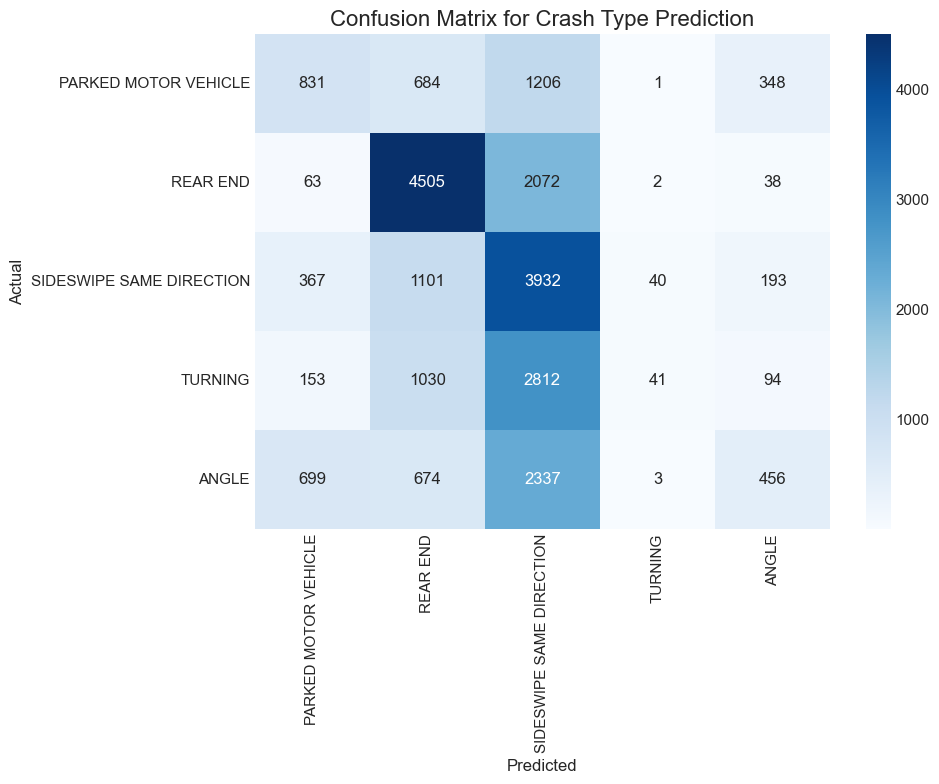

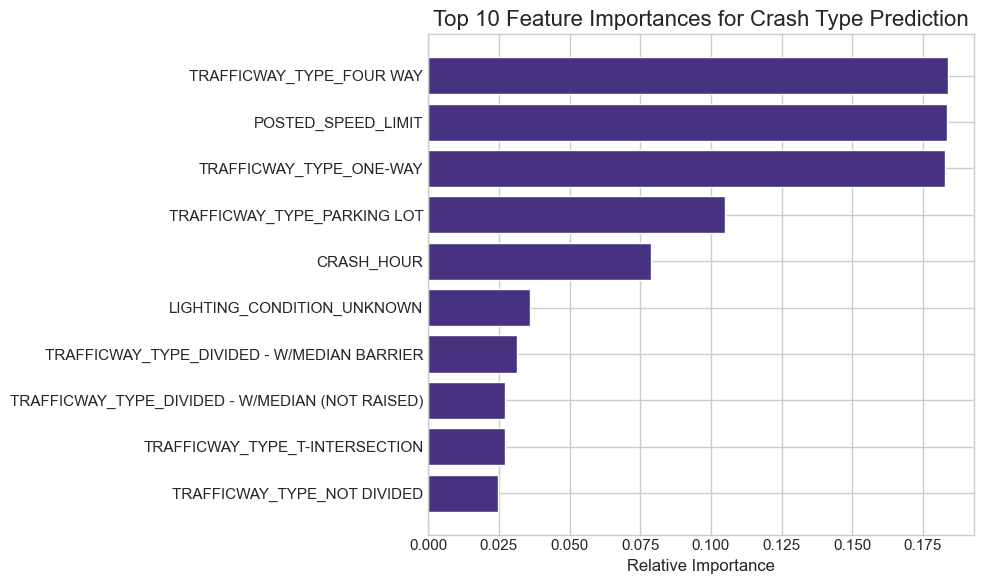

In [ ]:
# MODEL 1: Random Forest for Crash Type Prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# Check if DataFrame exists, if not, load it
if 'df' not in locals() and 'df' not in globals():
    print("Loading dataset...")
    df = pd.read_csv('processed_data/chicago_crashes_processed.csv')
    print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['TRAFFIC_CONTROL_DEVICE_encoded'] = le.fit_transform(df['TRAFFIC_CONTROL_DEVICE'].astype(str))


print("\nRANDOM FOREST FOR CRASH TYPE PREDICTION")
print("======================================")

# Column mapping for flexibility (check which columns exist)
weather_col = next((col for col in ['WEATHER_CATEGORY', 'weather_category', 'WEATHER_CONDITION']
                    if col in df.columns), None)
lighting_col = next((col for col in ['LIGHTING_CONDITION', 'lighting_condition']
                     if col in df.columns), None)
surface_col = next((col for col in ['ROADWAY_SURFACE_COND', 'roadway_surface_cond']
                    if col in df.columns), None)
trafficway_col = next((col for col in ['TRAFFICWAY_TYPE', 'trafficway_type']
                       if col in df.columns), None)
speed_col = next((col for col in ['POSTED_SPEED_LIMIT', 'posted_speed_limit']
                  if col in df.columns), None)
hour_col = next((col for col in ['CRASH_HOUR', 'crash_hour', 'CRASH_DATE_hour']
                 if col in df.columns), None)
weekend_col = next((col for col in ['WEEKEND', 'is_weekend', 'weekend']
                    if col in df.columns), None)
crash_type_col = next((col for col in ['FIRST_CRASH_TYPE', 'first_crash_type', 'crash_type_group']
                       if col in df.columns), None)

# Check if we have the required columns
required_cols = [weather_col, lighting_col, surface_col, trafficway_col,
                 speed_col, hour_col, weekend_col, crash_type_col]
missing_cols = [i for i, col in enumerate(required_cols) if col is None]

if missing_cols:
    missing_types = ["weather", "lighting", "surface", "trafficway",
                     "speed limit", "hour", "weekend", "crash type"][missing_cols]
    print(f"Missing required columns: {missing_types}")
    print("Available columns:", df.columns.tolist())
else:
    print(f"Using columns: {required_cols}")

    # Define features and target
    X = df[[weather_col, lighting_col, surface_col, trafficway_col,
            speed_col, hour_col, weekend_col]]
    y = df[crash_type_col]

    # Limit to top 5 crash types for simplicity
    top_5_crash_types = y.value_counts().head(5).index
    mask = y.isin(top_5_crash_types)
    X_filtered = X[mask]
    y_filtered = y[mask]

    # Take only 25% of the data for faster processing
    X_sample, _, y_sample, _ = train_test_split(X_filtered, y_filtered, test_size=0.75, random_state=42)
    print(f"Original dataset size: {len(X_filtered)}, Sample size: {len(X_sample)}")

    # Print top 5 crash types and their counts
    crash_type_counts = y_filtered.value_counts()
    print("\nTop 5 crash types:")
    for crash_type, count in crash_type_counts.items():
        print(f"- {crash_type}: {count} ({count/len(y_filtered)*100:.1f}%)")

    # Split the sampled data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    # Create preprocessing pipeline
    categorical_features = [weather_col, lighting_col, surface_col, trafficway_col]
    numerical_features = [speed_col, hour_col, weekend_col]

    # Create transformers for categorical and numerical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Combine transformers in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ])

    # Create the modeling pipeline with fewer trees for faster training
    rf_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42))
    ])

    # Create a baseline model that predicts the most common class
    baseline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DummyClassifier(strategy='most_frequent'))
    ])

    # Train the models
    print("\nTraining Random Forest model...")
    rf_model.fit(X_train, y_train)
    baseline.fit(X_train, y_train)
    print("Training complete!")

    # Evaluate the models
    y_pred = rf_model.predict(X_test)
    y_baseline = baseline.predict(X_test)

    print("\nRandom Forest Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Macro F1: {f1_score(y_test, y_pred, average='macro'):.4f}")
    print("\nBaseline Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_baseline):.4f}")
    print(f"Macro F1: {f1_score(y_test, y_baseline, average='macro'):.4f}")

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=top_5_crash_types,
                yticklabels=top_5_crash_types)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Crash Type Prediction')
    plt.tight_layout()
    plt.show()

    # Feature importance
    if hasattr(rf_model['classifier'], 'feature_importances_'):
        try:
            feature_names = (
                rf_model['preprocessor'].transformers_[0][1]['encoder'].get_feature_names_out(categorical_features).tolist() +
                numerical_features
            )
            importances = rf_model['classifier'].feature_importances_
            indices = np.argsort(importances)[-10:]  # Get indices of top 10 features

            plt.figure(figsize=(10, 6))
            plt.title('Top 10 Feature Importances for Crash Type Prediction')
            plt.barh(range(10), importances[indices], align='center')
            plt.yticks(range(10), [feature_names[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error generating feature importance plot: {e}")
            print("This is likely due to sklearn version differences in get_feature_names_out")

### Model 2: DBSCAN for Geographic Crash Hotspots – Results & Insights

- **Geographic Data Preparation & Sampling:**  
  We filtered the dataset to retain only valid and numeric latitude/longitude values, restricting the data to the Chicago area. For efficiency, a sample of the data was selected if the dataset was very large.

- **DBSCAN Clustering & Parameter Tuning:**  
  We applied DBSCAN to the scaled geographic coordinates. By testing several ε values, it determines an optimal parameter that yields a sensible number of clusters (typically between 5 and 20) while balancing the amount of noise. The output prints the number of clusters found and the percentage of noise points.

- **Cluster Visualization & Hotspot Analysis:**  
  A scatter plot illustrates the geographic clusters, showing noise points in gray and clustered points in distinct colors.  
  Furthermore, we analyzed the clusters by:
  - Reporting the center coordinates and size of the top clusters.
  - Listing the top crash types within each hotspot.
  - Providing a detailed view of the most significant hotspot, including a focused scatter plot and a bar plot of the crash type distribution.
This helped us to identify and visualize traffic crash hotspots in Chicago, highlighting where crashes cluster geographically and the common crash types in those hotspots.


## DBSCAN for Geographic Crash Hotspots and Visualizations Shruthi and Anand


DBSCAN FOR GEOGRAPHIC CRASH HOTSPOTS
Using geographic coordinates: LATITUDE, LONGITUDE
Geographic data after filtering: 557957 records
Using sample of 55795 points for DBSCAN

Testing different DBSCAN parameters...
eps=0.01: 2313 clusters, 18075 noise points (32.4%)
eps=0.05: 22 clusters, 82 noise points (0.1%)
eps=0.1: 4 clusters, 8 noise points (0.0%)
eps=0.15: 4 clusters, 5 noise points (0.0%)
eps=0.2: 3 clusters, 0 noise points (0.0%)

No optimal eps found, using default: 0.1
Final results: 4 clusters, 8 noise points (0.0%)


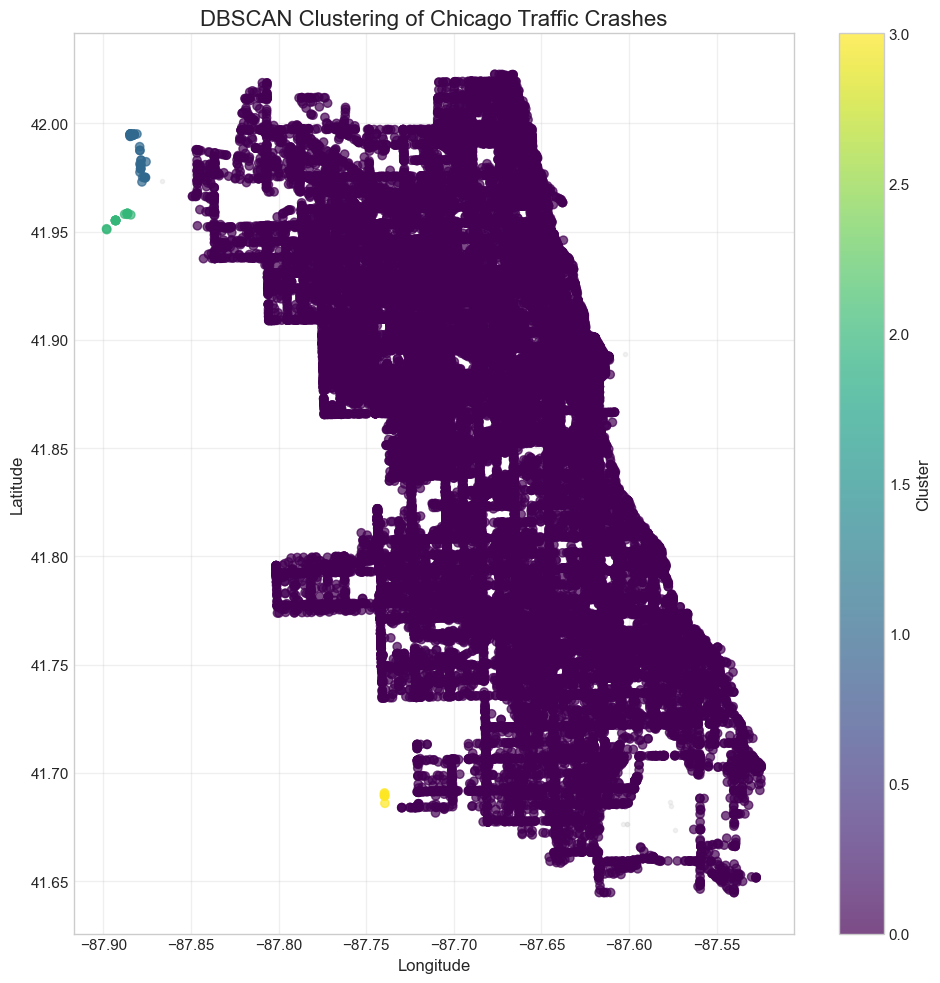


Top Crash Hotspots:

Hotspot 0 (55724 crashes):
Center: Lat=41.855309, Long=-87.678782
Top crash types:
  - PARKED MOTOR VEHICLE: 13203 (23.7%)
  - REAR END: 11248 (20.2%)
  - TURNING: 8384 (15.0%)

Hotspot 1 (41 crashes):
Center: Lat=41.987897, Long=-87.881063
Top crash types:
  - REAR END: 11 (26.8%)
  - SIDESWIPE SAME DIRECTION: 10 (24.4%)
  - FIXED OBJECT: 6 (14.6%)

Hotspot 2 (16 crashes):
Center: Lat=41.955994, Long=-87.890746
Top crash types:
  - REAR END: 9 (56.2%)
  - SIDESWIPE SAME DIRECTION: 4 (25.0%)
  - TURNING: 2 (12.5%)

Hotspot 3 (6 crashes):
Center: Lat=41.689173, Long=-87.739519
Top crash types:
  - REAR END: 4 (66.7%)
  - SIDESWIPE SAME DIRECTION: 1 (16.7%)
  - FIXED OBJECT: 1 (16.7%)


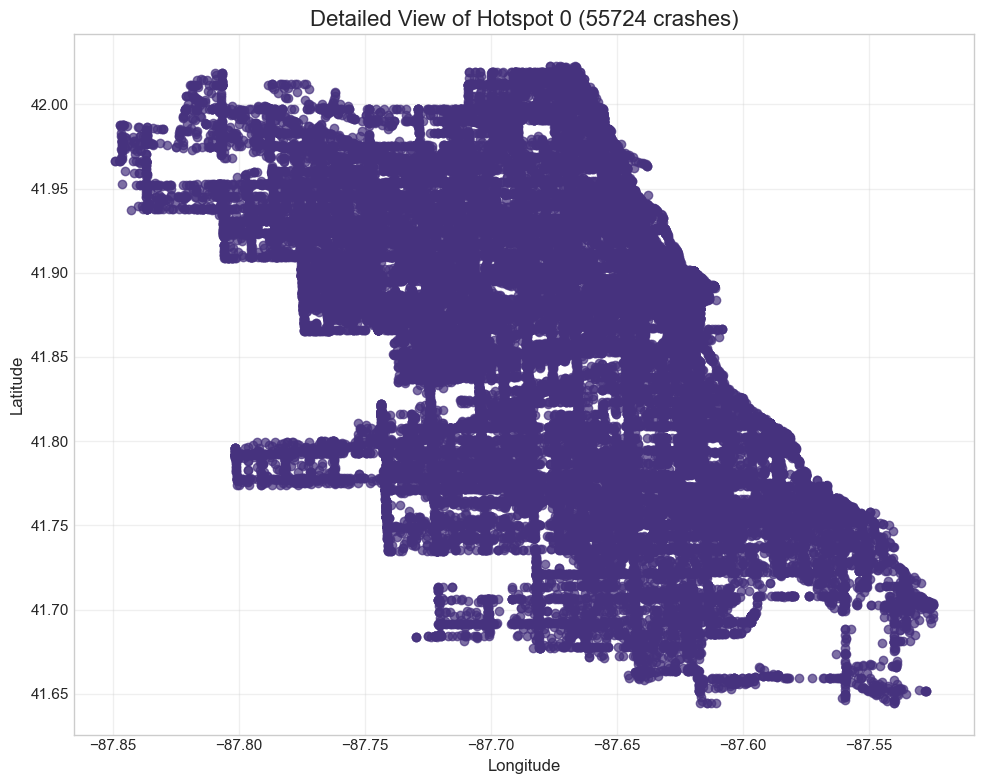

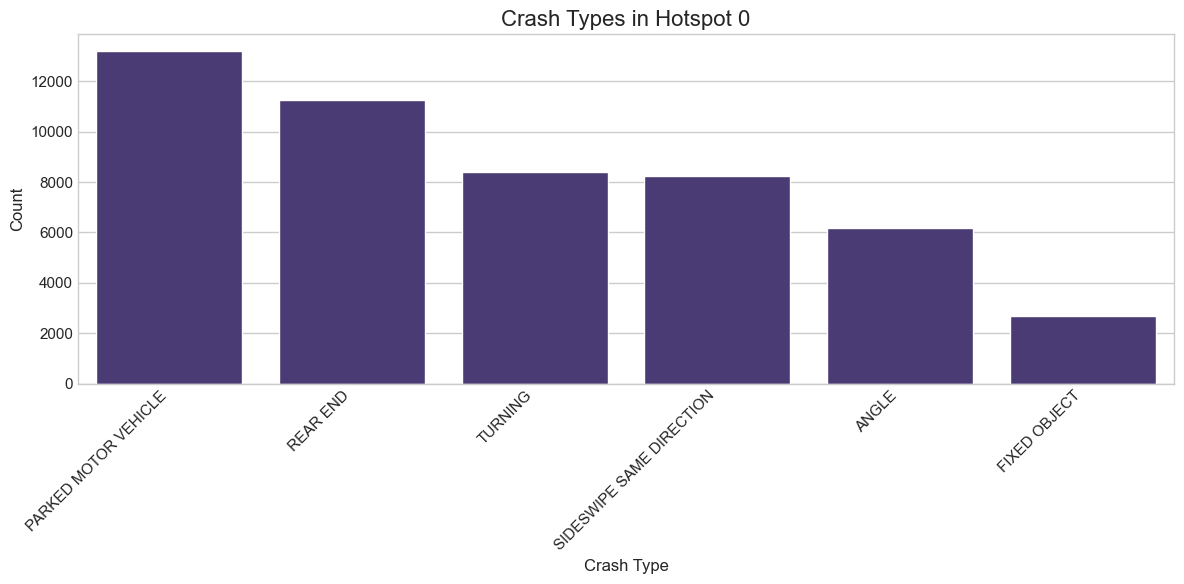

In [ ]:
# MODEL 2: DBSCAN for Geographic Crash Hotspots

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Check if DataFrame exists, if not, load it
if 'df' not in locals() and 'df' not in globals():
    print("Loading dataset...")
    df = pd.read_csv('processed_data/chicago_crashes_processed.csv')
    print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")

print("\nDBSCAN FOR GEOGRAPHIC CRASH HOTSPOTS")
print("===================================")

# Find latitude and longitude columns
lat_col = next((col for col in ['LATITUDE', 'latitude', 'LAT'] if col in df.columns), None)
lng_col = next((col for col in ['LONGITUDE', 'longitude', 'LONG', 'lng'] if col in df.columns), None)

if lat_col and lng_col:
    print(f"Using geographic coordinates: {lat_col}, {lng_col}")

    # Create a copy for geographic data
    geo_data = df.copy()

    # Filter out rows with missing coordinates
    geo_data = geo_data.dropna(subset=[lat_col, lng_col])

    # Make sure coordinates are numeric
    geo_data[lat_col] = pd.to_numeric(geo_data[lat_col], errors='coerce')
    geo_data[lng_col] = pd.to_numeric(geo_data[lng_col], errors='coerce')

    # Filter for Chicago area coordinates
    mask = (
        (geo_data[lat_col] > 41.6) &
        (geo_data[lat_col] < 42.1) &
        (geo_data[lng_col] > -87.9) &
        (geo_data[lng_col] < -87.5)
    )
    geo_data = geo_data[mask]

    print(f"Geographic data after filtering: {len(geo_data)} records")

    # Take a sample if dataset is very large
    if len(geo_data) > 10000:
        geo_sample, _ = train_test_split(geo_data, test_size=0.9, random_state=42)
        print(f"Using sample of {len(geo_sample)} points for DBSCAN")
    else:
        geo_sample = geo_data

    # Extract coordinates for clustering
    coords = geo_sample[[lat_col, lng_col]].values

    # Scale the coordinates for DBSCAN
    coord_scaler = StandardScaler()
    coords_scaled = coord_scaler.fit_transform(coords)

    # Apply DBSCAN - try different eps values if needed
    eps_values = [0.01, 0.05, 0.1, 0.15, 0.2]
    best_eps = None
    best_n_clusters = 0

    print("\nTesting different DBSCAN parameters...")
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(coords_scaled)

        # Count clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(labels) * 100

        print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points ({noise_pct:.1f}%)")

        # Choose the eps value that gives a reasonable number of clusters (5-20)
        if 5 <= n_clusters <= 20 and (best_eps is None or n_clusters > best_n_clusters):
            best_eps = eps
            best_n_clusters = n_clusters

    # If no good eps value found, use default
    if best_eps is None:
        best_eps = 0.1
        print(f"\nNo optimal eps found, using default: {best_eps}")
    else:
        print(f"\nSelected eps={best_eps} with {best_n_clusters} clusters")

    # Run DBSCAN with selected parameters
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    geo_sample['DBSCAN_Cluster'] = dbscan.fit_predict(coords_scaled)

    # Count clusters and noise points
    clusters = set(geo_sample['DBSCAN_Cluster'])
    n_clusters = len(clusters) - (1 if -1 in clusters else 0)
    n_noise = list(geo_sample['DBSCAN_Cluster']).count(-1)
    print(f"Final results: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(geo_sample)*100:.1f}%)")

    # Create scatter plot of clusters
    plt.figure(figsize=(10, 10))

    # Plot noise points in gray
    noise_points = geo_sample[geo_sample['DBSCAN_Cluster'] == -1]
    plt.scatter(
        noise_points[lng_col],
        noise_points[lat_col],
        c='lightgray',
        marker='.',
        alpha=0.3,
        label='Noise'
    )

    # Plot clusters with different colors
    clustered_points = geo_sample[geo_sample['DBSCAN_Cluster'] != -1]
    if len(clustered_points) > 0:
        scatter = plt.scatter(
            clustered_points[lng_col],
            clustered_points[lat_col],
            c=clustered_points['DBSCAN_Cluster'],
            cmap='viridis',
            marker='o',
            alpha=0.7
        )
        plt.colorbar(scatter, label='Cluster')

    plt.title('DBSCAN Clustering of Chicago Traffic Crashes')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Analyze clusters
    if n_clusters > 0:
        # Find crash type column
        crash_type_col = next((col for col in ['FIRST_CRASH_TYPE', 'first_crash_type', 'crash_type_group']
                             if col in df.columns), None)

        if crash_type_col:
            # Analyze top clusters (biggest ones)
            cluster_sizes = geo_sample['DBSCAN_Cluster'].value_counts()
            top_clusters = cluster_sizes[cluster_sizes.index != -1].head(5)

            print("\nTop Crash Hotspots:")
            print("====================")

            for cluster_id, size in top_clusters.items():
                cluster_data = geo_sample[geo_sample['DBSCAN_Cluster'] == cluster_id]

                # Cluster center coordinates
                center_lat = cluster_data[lat_col].mean()
                center_lng = cluster_data[lng_col].mean()

                # Most common crash types
                crash_types = cluster_data[crash_type_col].value_counts().head(3)

                print(f"\nHotspot {cluster_id} ({size} crashes):")
                print(f"Center: Lat={center_lat:.6f}, Long={center_lng:.6f}")
                print("Top crash types:")
                for crash_type, count in crash_types.items():
                    print(f"  - {crash_type}: {count} ({count/size*100:.1f}%)")

            # Visualize the top hotspot
            top_cluster_id = top_clusters.index[0]
            top_hotspot = geo_sample[geo_sample['DBSCAN_Cluster'] == top_cluster_id]

            plt.figure(figsize=(10, 8))
            plt.scatter(top_hotspot[lng_col], top_hotspot[lat_col], alpha=0.7)
            plt.title(f'Detailed View of Hotspot {top_cluster_id} ({len(top_hotspot)} crashes)')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Crash type distribution in top hotspot
            plt.figure(figsize=(12, 6))
            crash_counts = top_hotspot[crash_type_col].value_counts().head(6)
            sns.barplot(x=crash_counts.index, y=crash_counts.values)
            plt.title(f'Crash Types in Hotspot {top_cluster_id}')
            plt.xlabel('Crash Type')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
else:
    print("Could not find latitude and longitude columns. Cannot perform geographic clustering.")

## Time Series Analysis for Temporal Patterns and Visualizations Malleshwar, Karthik, Shruthi, and Siddhi

### Model 3: Time Series Analysis for Temporal Patterns – Results & Insights

- **Date Processing:**  
  We ensured that the crash date column is in proper datetime format (or reconstructs it from separate year, month, and day columns if needed) and reports the overall date range of the data.

- **Time Series Plots:**  
  It calculates daily crash counts and then resamples these counts to create smoother weekly and monthly trends. Each resampled time series is visualized with its own plot, showing how crash frequency changes over time.

- **Seasonal Decomposition:**  
  When sufficient data and the `statsmodels` package are available, this code performs an additive seasonal decomposition (using a period of 52 weeks) to separate the observed crash counts into trend, seasonal, and residual components. This helps to pinpoint underlying patterns and seasonality in the data.

- **Day of Week & Hourly Patterns:**  
  This analysis helped us further explore following temporal variations by:
  - Plotting a bar chart of crash counts by day of the week.
  - Visualizing hourly crash patterns with a bar chart.
  - Comparing the hourly distribution of crashes on weekdays versus weekends via line plots, highlighting differences in crash occurrence throughout the day.

- **Monthly & Seasonal Patterns:**  
  We examined monthly patterns by mapping month numbers to month names and visualizing crash counts by month. It also presents crash frequencies by season if that information is available.

This analysis provides a comprehensive view of how crash occurrences vary over different time scales—from daily to seasonal—revealing trends and patterns that can inform further investigation.



TIME SERIES ANALYSIS FOR TEMPORAL PATTERNS
Using date column: CRASH_DATE
Date range: 2020-01-01 00:00:00 to 2025-04-10 01:45:00


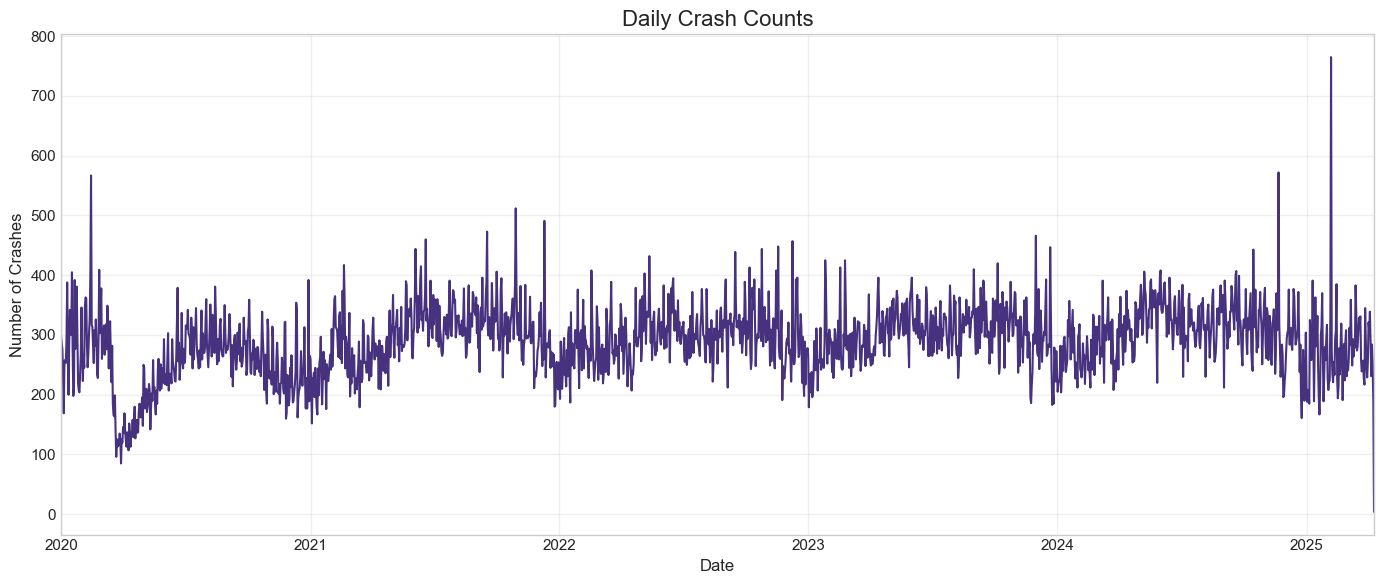

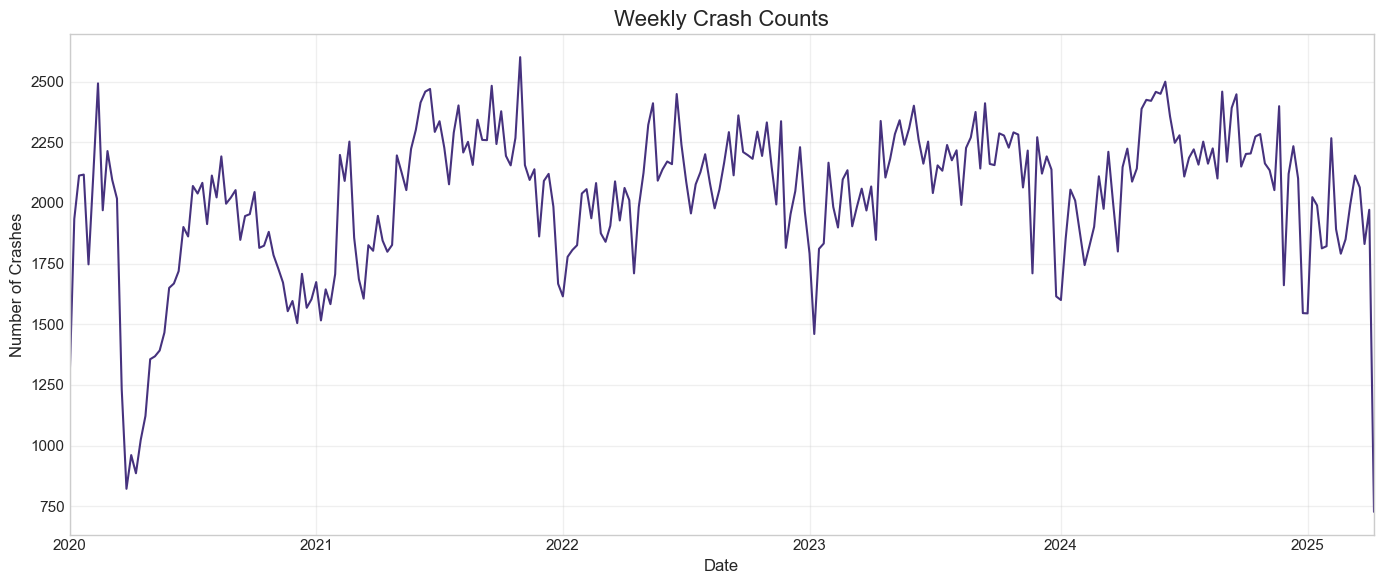

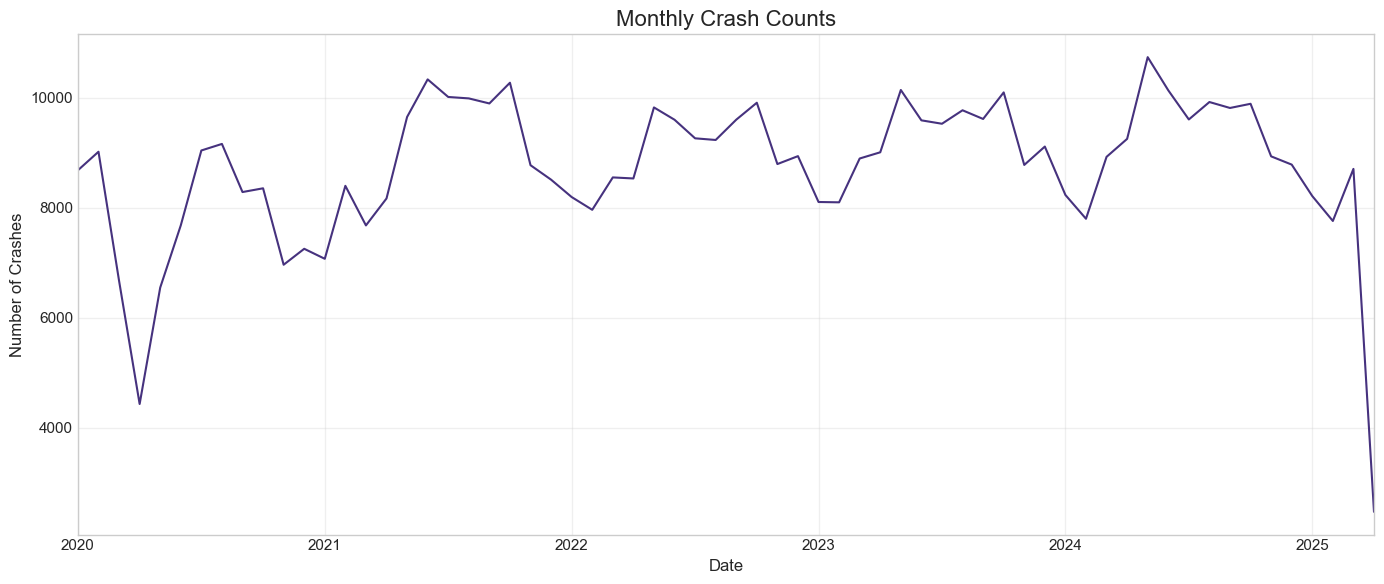


Performing seasonal decomposition...


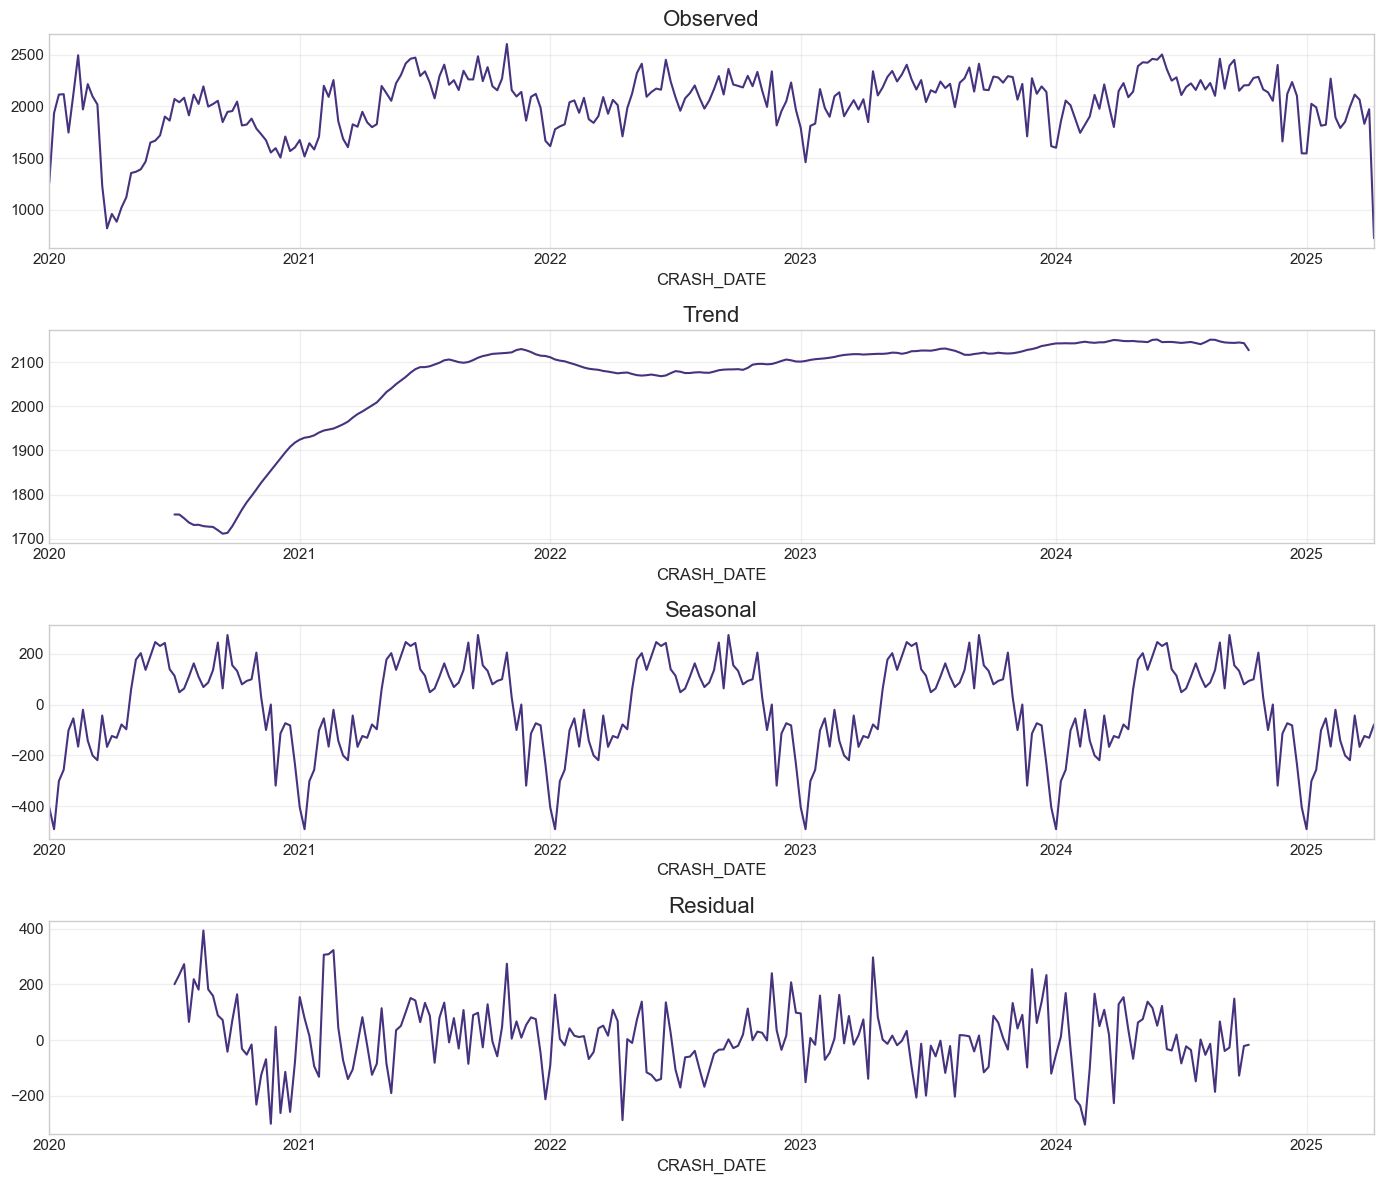


Analyzing day of week patterns using column: CRASH_DAY_OF_WEEK


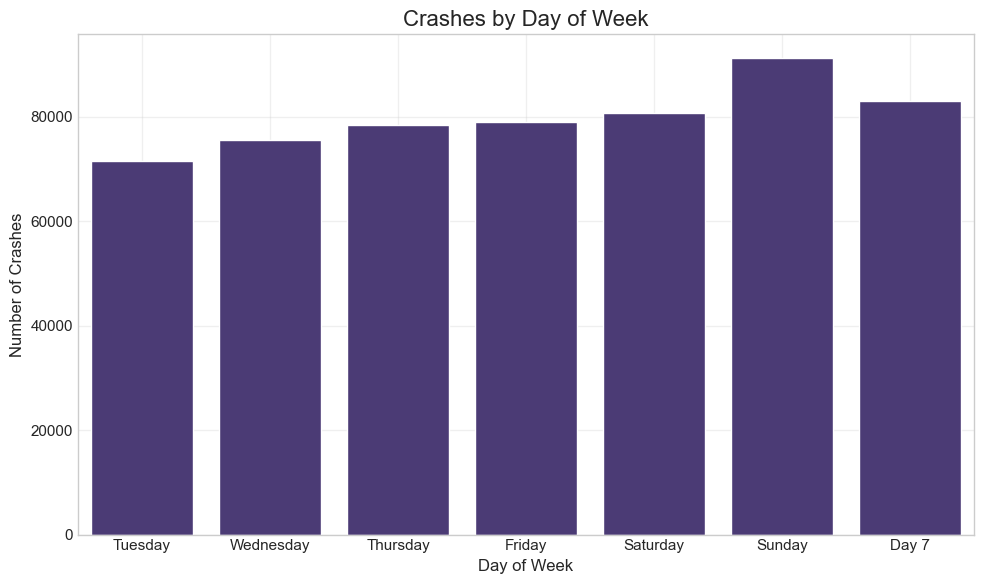

Analyzing hour of day patterns using column: CRASH_HOUR


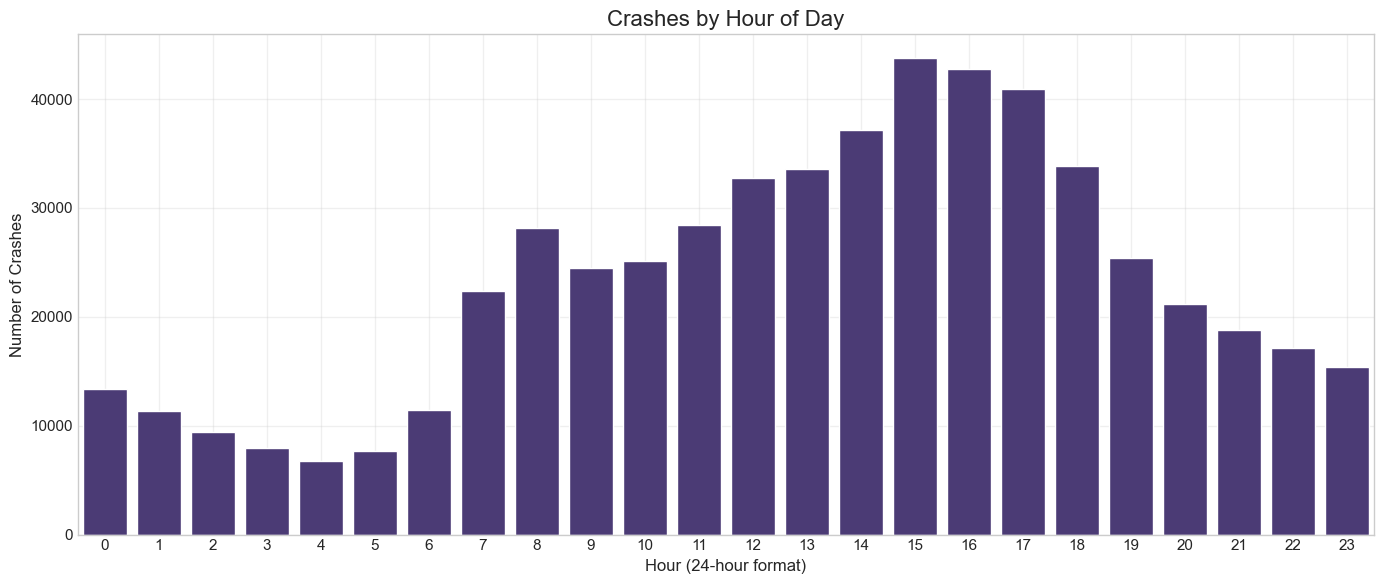

Analyzing weekday vs. weekend patterns


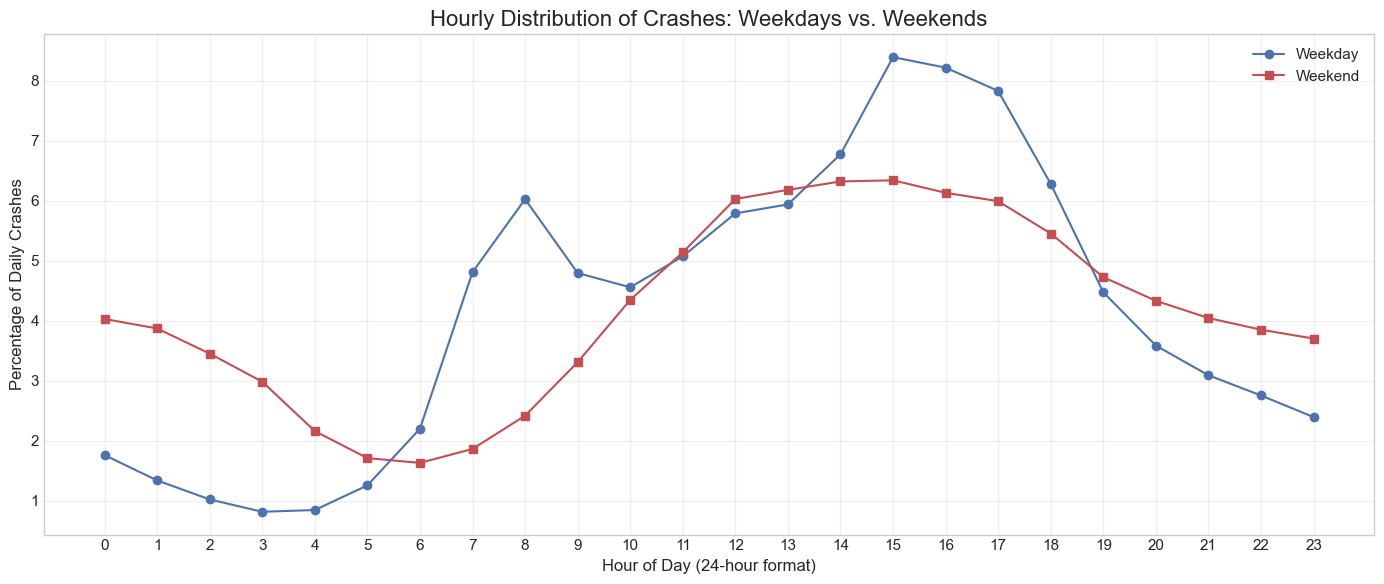

Analyzing monthly patterns


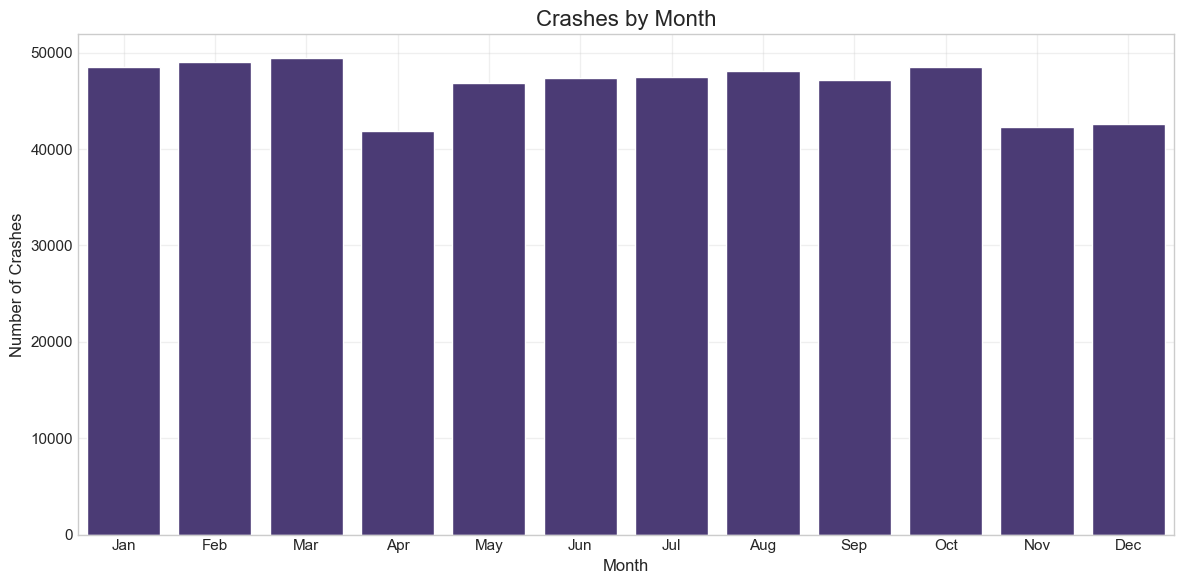

Analyzing seasonal patterns


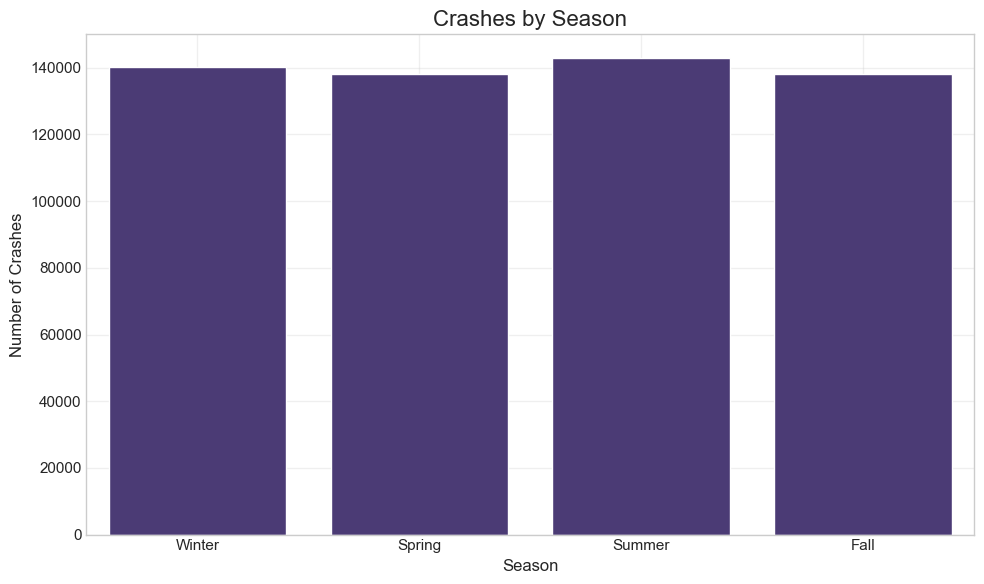

In [ ]:
# MODEL 5: Time Series Analysis for Temporal Patterns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Try to import statsmodels for seasonal decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    statsmodels_available = True
except ImportError:
    print("statsmodels not installed. Some time series analyses will be limited.")
    statsmodels_available = False

# Check if DataFrame exists, if not, load it
if 'df' not in locals() and 'df' not in globals():
    print("Loading dataset...")
    df = pd.read_csv('processed_data/chicago_crashes_processed.csv')
    print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")

print("\nTIME SERIES ANALYSIS FOR TEMPORAL PATTERNS")
print("=========================================")

# Find date column
date_col = next((col for col in ['CRASH_DATE', 'crash_date'] if col in df.columns), None)

if date_col:
    # Make sure it's datetime format
    if not pd.api.types.is_datetime64_dtype(df[date_col]):
        try:
            df[date_col] = pd.to_datetime(df[date_col])
            print(f"Converted {date_col} to datetime")
        except:
            print(f"Failed to convert {date_col} to datetime - attempting to find alternate columns")
            date_col = None

# If primary date column not found or conversion failed, try alternate columns
if date_col is None:
    # Look for year, month, day columns
    year_col = next((col for col in ['CRASH_DATE_year', 'crash_year', 'CRASH_YEAR']
                     if col in df.columns), None)
    month_col = next((col for col in ['CRASH_DATE_month', 'crash_month', 'CRASH_MONTH', 'MONTH_NUM']
                      if col in df.columns), None)
    day_col = next((col for col in ['CRASH_DATE_day', 'crash_day', 'CRASH_DAY', 'DAY_OF_MONTH']
                    if col in df.columns), None)

    if year_col and month_col and day_col:
        print(f"Creating date from {year_col}, {month_col}, {day_col}")
        try:
            # Create date column from year, month, day
            df['reconstructed_date'] = pd.to_datetime(
                df[year_col].astype(str) + '-' +
                df[month_col].astype(str) + '-' +
                df[day_col].astype(str)
            )
            date_col = 'reconstructed_date'
        except Exception as e:
            print(f"Failed to create date: {e}")

if date_col:
    print(f"Using date column: {date_col}")
    print(f"Date range: {df[date_col].min()} to {df[date_col].max()}")

    # 1. Daily crash counts
    daily_crashes = df.groupby(df[date_col].dt.date).size()
    crash_ts = pd.Series(daily_crashes, index=pd.DatetimeIndex(daily_crashes.index))

    # Plot time series
    plt.figure(figsize=(14, 6))
    crash_ts.plot()
    plt.title('Daily Crash Counts')
    plt.xlabel('Date')
    plt.ylabel('Number of Crashes')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Weekly resampling for smoother trends
    weekly_crashes = crash_ts.resample('W').sum()

    plt.figure(figsize=(14, 6))
    weekly_crashes.plot()
    plt.title('Weekly Crash Counts')
    plt.xlabel('Date')
    plt.ylabel('Number of Crashes')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Monthly pattern
    monthly_crashes = crash_ts.resample('M').sum()

    plt.figure(figsize=(14, 6))
    monthly_crashes.plot()
    plt.title('Monthly Crash Counts')
    plt.xlabel('Date')
    plt.ylabel('Number of Crashes')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Seasonal decomposition (if statsmodels available)
    if statsmodels_available and len(weekly_crashes) >= 52:
        try:
            print("\nPerforming seasonal decomposition...")
            decomposition = seasonal_decompose(weekly_crashes, model='additive', period=52)

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

            decomposition.observed.plot(ax=ax1)
            ax1.set_title('Observed')
            ax1.grid(True, alpha=0.3)

            decomposition.trend.plot(ax=ax2)
            ax2.set_title('Trend')
            ax2.grid(True, alpha=0.3)

            decomposition.seasonal.plot(ax=ax3)
            ax3.set_title('Seasonal')
            ax3.grid(True, alpha=0.3)

            decomposition.resid.plot(ax=ax4)
            ax4.set_title('Residual')
            ax4.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error in seasonal decomposition: {e}")
    elif statsmodels_available:
        print("Not enough data for seasonal decomposition (need at least 1 year of data)")

    # 5. Patterns by day of week
    # Find day of week column
    dow_col = next((col for col in ['CRASH_DAY_OF_WEEK', 'DAY_OF_WEEK', 'CRASH_DATE_dayofweek',
                                    'crash_day', 'CRASH_DAY']
                   if col in df.columns), None)

    if dow_col:
        print(f"\nAnalyzing day of week patterns using column: {dow_col}")

        # Check if it's already a number or needs to be converted
        if df[dow_col].dtype in ['int64', 'float64']:
            # Numeric days - assume 0 = Monday
            dow_values = df[dow_col]
            day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        else:
            # Try to convert text days to numeric (or use original)
            try:
                day_mapping = {
                    'MONDAY': 0, 'Monday': 0, 'monday': 0, 'MON': 0, 'Mon': 0,
                    'TUESDAY': 1, 'Tuesday': 1, 'tuesday': 1, 'TUE': 1, 'Tue': 1,
                    'WEDNESDAY': 2, 'Wednesday': 2, 'wednesday': 2, 'WED': 2, 'Wed': 2,
                    'THURSDAY': 3, 'Thursday': 3, 'thursday': 3, 'THU': 3, 'Thu': 3,
                    'FRIDAY': 4, 'Friday': 4, 'friday': 4, 'FRI': 4, 'Fri': 4,
                    'SATURDAY': 5, 'Saturday': 5, 'saturday': 5, 'SAT': 5, 'Sat': 5,
                    'SUNDAY': 6, 'Sunday': 6, 'sunday': 6, 'SUN': 6, 'Sun': 6
                }
                dow_values = df[dow_col].map(lambda x: day_mapping.get(str(x), x))
                day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            except:
                # If conversion fails, use original values
                dow_values = df[dow_col]
                day_names = sorted(df[dow_col].unique())

        # Count crashes by day of week
        day_counts = dow_values.value_counts().sort_index()

        plt.figure(figsize=(10, 6))
        try:
            # Try to assign proper day names
            if len(day_names) >= len(day_counts):
                labels = [day_names[i] if i < len(day_names) else f"Day {i}" for i in day_counts.index]
            else:
                labels = [f"Day {i}" for i in day_counts.index]

            sns.barplot(x=labels, y=day_counts.values)
        except:
            # Fallback - raw values
            sns.barplot(x=day_counts.index, y=day_counts.values)

        plt.title('Crashes by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Crashes')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 6. Hour of day patterns
    hour_col = next((col for col in ['CRASH_HOUR', 'CRASH_DATE_hour', 'crash_hour', 'HOUR_OF_DAY']
                    if col in df.columns), None)

    if hour_col:
        print(f"Analyzing hour of day patterns using column: {hour_col}")

        # Count crashes by hour
        hour_counts = df[hour_col].value_counts().sort_index()

        plt.figure(figsize=(14, 6))
        sns.barplot(x=hour_counts.index, y=hour_counts.values)
        plt.title('Crashes by Hour of Day')
        plt.xlabel('Hour (24-hour format)')
        plt.ylabel('Number of Crashes')
        plt.xticks(range(0, 24))
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Weekend vs. Weekday
        weekend_col = next((col for col in ['WEEKEND', 'is_weekend', 'weekend']
                           if col in df.columns), None)

        if weekend_col:
            print("Analyzing weekday vs. weekend patterns")

            # Split by weekend/weekday
            weekday_crashes = df[df[weekend_col] == 0]
            weekend_crashes = df[df[weekend_col] == 1]

            # Count by hour
            weekday_hours = weekday_crashes[hour_col].value_counts().sort_index()
            weekend_hours = weekend_crashes[hour_col].value_counts().sort_index()

            # Normalize to show percentage
            weekday_hours_pct = weekday_hours / weekday_hours.sum() * 100
            weekend_hours_pct = weekend_hours / weekend_hours.sum() * 100

            plt.figure(figsize=(14, 6))
            plt.plot(weekday_hours_pct.index, weekday_hours_pct.values, 'b-', marker='o', label='Weekday')
            plt.plot(weekend_hours_pct.index, weekend_hours_pct.values, 'r-', marker='s', label='Weekend')
            plt.title('Hourly Distribution of Crashes: Weekdays vs. Weekends')
            plt.xlabel('Hour of Day (24-hour format)')
            plt.ylabel('Percentage of Daily Crashes')
            plt.xticks(range(0, 24))
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

    # 7. Monthly or seasonal patterns
    month_col = next((col for col in ['CRASH_DATE_month', 'CRASH_MONTH', 'MONTH_NUM', 'crash_month']
                     if col in df.columns), None)

    if month_col:
        print("Analyzing monthly patterns")

        # Count crashes by month
        month_counts = df[month_col].value_counts().sort_index()

        plt.figure(figsize=(12, 6))
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        try:
            # Try to map numeric months to names
            if month_counts.index.max() <= 12:
                labels = [month_names[i-1] if 1 <= i <= 12 else f"Month {i}" for i in month_counts.index]
                sns.barplot(x=labels, y=month_counts.values)
            else:
                sns.barplot(x=month_counts.index, y=month_counts.values)
        except:
            # Fallback to numeric display
            sns.barplot(x=month_counts.index, y=month_counts.values)

        plt.title('Crashes by Month')
        plt.xlabel('Month')
        plt.ylabel('Number of Crashes')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Season pattern
        season_col = next((col for col in ['SEASON', 'season'] if col in df.columns), None)

        if season_col:
            print("Analyzing seasonal patterns")

            # Count by season
            season_counts = df[season_col].value_counts()

            # Try to order seasons properly
            try:
                seasons_ordered = ['Winter', 'Spring', 'Summer', 'Fall']
                season_counts = season_counts.reindex(seasons_ordered)
            except:
                pass

            plt.figure(figsize=(10, 6))
            sns.barplot(x=season_counts.index, y=season_counts.values)
            plt.title('Crashes by Season')
            plt.xlabel('Season')
            plt.ylabel('Number of Crashes')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
else:
    print("Could not find or create a date column for time series analysis.")


# Team Members

| Team Member                         | Email             | GitHub Link                                                     |
|-------------------------------------|-------------------|-----------------------------------------------------------------|
| Karthik Kumar Muppala               | kmupp@uic.edu     | [GitHub Profile](https://github.com/m-karthik-kumar)            |
| Kodati Shruthi                      | skoda13@uic.edu   | [GitHub Profile](https://github.com/Shruthikodati)               |
| Siddhi Dabholkar                    | sdabh@uic.edu     | [GitHub Profile](https://github.com/siddhidabholkar10)            |
| Meena Anand                         | ameen4@uic.edu    | [GitHub Profile](https://github.com/Anandm0101)                   |
| Naga Malleshwar Reddy Lingala       | nling4@uic.edu    | [GitHub Profile](https://github.com/malleshwar)                   |

# Contribution

| Contribution                                                    | Team Members                                     |
|-----------------------------------------------------------------|--------------------------------------------------|
| ETL and Data Preprocessing, Cleaning, and Visualizations        | Anand and Siddhi                                 |
| Random Forest for Crash Type Prediction and Visualizations      | Malleshwar and Karthik                           |
| DBSCAN for Geographic Crash Hotspots and Visualizations           | Shruthi and Anand                                |
| Time Series Analysis for Temporal Patterns and Visualizations     | Malleshwar, Karthik, Shruthi, and Siddhi         |

# Chicago Traffic Crashes Analysis: Project Reflection

## 1. What is the most challenging part of the project that you've encountered so far?

The biggest challenge has been handling data quality issues. The raw crash dataset contains a considerable amount of noise and missing values, especially in key variables such as environmental conditions and spatial coordinates. In addition, fine-tuning clustering parameters (like the ε value in DBSCAN) to identify meaningful geographic hotspots without overfitting the noisy data has proven to be difficult.

Our ETL pipeline needed to process approximately 933,842 records with 48 original columns, requiring robust handling of numerous missing values. Particularly challenging was the decision framework for which columns to drop versus impute, as 8 columns had over 90% missing values and another 3 had between 50-90% missing data.

## 2. What are your initial insights?

Our initial exploration has yielded several valuable insights:
- **Temporal Trends:** The analysis reveals clear variations in crash frequency over different time frames (daily, weekly, and monthly), with noticeable peaks during weekends and late-night hours.
- **Geographic Hotspots:** Clustering using DBSCAN shows distinct crash hotspots in certain areas of Chicago, suggesting localized issues that may be linked to infrastructure or environmental factors.
- **Environmental and Crash Type Relationships:** Visualizations indicate that factors such as weather, lighting conditions, and speed limits have significant impacts on both crash severity and crash type.

## 3. Are there any concrete results you can show at this point? If not, why not?

Yes, we have several concrete results:
- A comprehensive ETL pipeline that successfully processes the entire dataset (933,842 records), removing columns with excessive missing values while adding 11 derived features through feature engineering. This pipeline has successfully filtered the data to include only crashes from 2020 onwards (559,208 records).
- Exploratory visualizations effectively capture temporal patterns, spatial clusters, and the influence of environmental conditions.
- Developed a Random Forest model for crash type prediction has been developed and shows promising performance against a baseline model.

These results demonstrate that our methodology is sound, although further refinement and validation are still needed.

## 4. Going forward, what are the current biggest problems you're facing?

Key issues that remain include:
- **Data Quality:** Enhancing imputation techniques or integrating additional data sources may help. The data.cityofchicago.org has multiple other datasets such as information regarding vehicles and people involved in the crashes. We aspire to include those datasets to better understand the complete picture.
- **Parameter Tuning:** Optimizing parameters for the clustering and predictive models is essential to improve performance without overfitting.
- **Scalability:** Processing and analyzing the complete dataset without excessive computational overhead will be a challenge, especially as we've now successfully incorporated all 559,208 records from 2020 onwards in our analysis.
- **Model Generalization:** Ensuring that our models generalize well across the full dataset and different conditions is an ongoing concern.

## 5. Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?

Overall, the project is on track. We have built a robust processing pipeline for the entire dataset and produced insightful visualizations and initial models. However, more time is needed to:
- Enhance data cleaning and imputation strategies
- Include relatable datasets to the existing data that we have.
- Refine feature engineering and model hyperparameter tuning, and
- Optimize our analytical workflow to handle the full dataset efficiently.

## 6. Given your initial exploration of the data, is it worth proceeding with your project?

Yes, it is worth proceeding. The initial exploration has uncovered significant trends and actionable insights—such as temporal crash patterns and geographic hotspots—that can inform traffic safety interventions and urban planning. These promising early results validate the potential of our analysis and justify continued development of more refined predictive models.

## Concrete Plans and Goals for the Next Month

### Data Enhancement
- Complete integration of vehicle and people datasets from data.cityofchicago.org
- Implement advanced spatial features extraction using Chicago's road network data
- Develop comprehensive feature selection based on variance inflation factor analysis
- Create a unified data dictionary with clear definitions and transformations

### Model Refinement
- **Random Forest Model**:
  - Complete cross-validation and hyperparameter optimization
  - Implement feature importance analysis and partial dependence plots
  - Develop ensemble approach combining multiple specialized models

- **XGBoost Implementation**:
  - Set up gradient boosting framework with early stopping to prevent overfitting
  - Optimize hyperparameters using Bayesian optimization approaches
  - Compare performance against Random Forest baseline and analyze trade-offs
  - Implement SHAP values for enhanced model interpretability

- **DBSCAN Clustering**:
  - Finalize clustering parameters through systematic grid search
  - Implement hierarchical clustering to identify crash hotspot taxonomies
  - Integrate temporal dimensions into spatial clustering

- **Temporal Analysis**:
  - Implement ARIMA models for crash frequency forecasting
  - Develop time-series decomposition to isolate trend, seasonal, and cyclical components
  - Create intervention analysis framework to evaluate policy impacts

### Advanced Modeling Exploration
- **LLM Integration**:
  - Develop prompt engineering strategies for crash narrative analysis
  - Implement language models to extract detailed crash circumstances from text descriptions
  - Create a classification system for nuanced crash types beyond traditional categories


### Results Integration & Visualization
- Develop interactive dashboard combining model outputs with geographic visualization
- Create risk score framework integrating insights from all modeling approaches
- Generate targeted safety recommendations for top 10 highest-risk locations
- Prepare final technical documentation and methodology validation